# Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import itertools
import scipy.stats as stats
from scipy.stats import entropy

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.colors as pc
import plotly.graph_objects as go

import nltk
from nltk.tokenize import word_tokenize
import textwrap
from collections import Counter
import ast
from wordcloud import WordCloud

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from transformers import TrainerCallback
from sentence_transformers import SentenceTransformer

In [2]:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
df = pd.read_csv("All_Jokes_API.csv")
df = df.drop(columns=["Temperature"])
df

Joke Number                                       Joke Content  \
0               1  In the mythical lands of TechTopia, an IT depa...   
1               2  In the bustling IT department of Mythical Ente...   
2               3  In the bustling land of Techtopia, a grumpy dr...   
3               4  In the magical IT department of Fantasia Corp,...   
4               5  In a bustling IT office, a griffin, a unicorn,...   
...           ...                                                ...   
1445           96  In the depths of space, astronaut Zara encount...   
1446           97  In the vast expanse of space, astronaut Zed fl...   
1447           98  Captain Zogg piloted his starship into the hea...   
1448           99  In the vast abyss of space, a cosmic jellyfish...   
1449          100  In the depths of space, Captain Nebula met a s...   

           Group Topic  
0             4o    IT  
1             4o    IT  
2             4o    IT  
3             4o    IT  
4             4o    IT  
...          ...   ...  
1445  o1-preview     S  
1446  o1-preview     S  
1447  o1-preview     S  
1448  o1-preview     S  
1449  o1-preview     S  

[1450 rows x 4 columns]

In [ ]:
for i in range(10):
    joke = df.iloc[i]['Joke Content'].replace('\n', ' ').strip()
    print(f"{i}. {joke}")

0. In the mythical lands of TechTopia, an IT department was run by a team of fantastic creatures. The lead coder was a wizard named Bytebeard, who could debug code with a flick of his wand. His assistant, Pixie Ping, specialized in network magic, instantly fixing connectivity issues with a sprinkle of fairy dust.  One day, when the servers were down, Bytebeard cast his famous spell, "Ctrl-Alt-Abracadabra!" The servers hummed back to life. Pixie Ping giggled, "Good thing you didn't Ctrl-Alt-Delete us all!"  The griffin in HR chimed in, "If only invoicing was as magical!"
1. In the bustling IT department of Mythical Enterprises, a team of fantastic creatures was hard at work. The centaur, known for his multitasking, clopped around balancing a laptop on his back, while being the best IT “hoof” support. The dragon, known for his fiery code debugging, had to be reminded constantly not to roast the servers during heated coding “bouts.” Meanwhile, the gnome managed the network, always “gnomin

In [ ]:
df_sampled = (
    df.groupby(['Group', 'Topic'], group_keys=False)
      .apply(lambda x: x.sample(n=min(25, len(x)), random_state=42))
      .reset_index(drop=True)
)

df_sampled['Joke Number'] = (
    df_sampled.groupby(['Group', 'Topic']).cumcount() + 1
)

df = df_sampled.copy()
df

<ipython-input-5-7d836717421d>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min(25, len(x)), random_state=42))


Joke Number                                       Joke Content  \
0              1  In an IT office nestled in a magical forest, a...   
1              2  In the mystical land of Technotopia, a band of...   
2              3  In a bustling IT firm, three fantastic creatur...   
3              4  In the enchanted realm of Silicon Valleywood, ...   
4              5  In a mystical land where magical creatures coe...   
..           ...                                                ...   
195           21  Captain Nebula stood on the bridge of the Star...   
196           22  Captain Quark gazed into the cosmic abyss; une...   
197           23  In deep space, astronaut Zogg finds a cosmic v...   
198           24  In the furthest reaches of the galaxy, Command...   
199           25  In the depths of the universe, Captain Nebula ...   

          Group Topic  
0            4o    IT  
1            4o    IT  
2            4o    IT  
3            4o    IT  
4            4o    IT  
..          ...   ...  
195  o1-preview     S  
196  o1-preview     S  
197  o1-preview     S  
198  o1-preview     S  
199  o1-preview     S  

[200 rows x 4 columns]

# Group Comparison

In [4]:
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
def get_char_count(text):
    return len(text)  # Количество символов в тексте

def get_word_count(text):
    words = word_tokenize(text.lower())
    return len(words)  # Общее количество слов

def get_unique_word_count(text):
    words = word_tokenize(text.lower())  # Токенизация + приведение к нижнему регистру
    return len(set(words))  # Количество уникальных слов

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return " ".join(filtered_words)

**Без удаления стоп слов**

In [ ]:
df["Char_Count"] = df["Joke Content"].apply(get_char_count)
df["Word_Count"] = df["Joke Content"].apply(get_word_count)
df["Unique_Word_Count"] = df["Joke Content"].apply(get_unique_word_count)


In [ ]:
group_summary = df.groupby("Group").agg(
    Total_Char_Count=("Char_Count", "sum"),
    Total_Word_Count=("Word_Count", "sum"),
    Unique_Words=("Joke Content", lambda texts: len(set(word_tokenize(" ".join(texts).lower()))))
).reset_index()
group_summary["Words_per_Unique_Word"] = group_summary["Total_Word_Count"] / group_summary["Unique_Words"]
group_summary

Group  Total_Char_Count  Total_Word_Count  Unique_Words  \
0          4o             28382              5717          1472   
1       Human             18975              4030          1303   
2     o1-mini             31986              6073          1312   
3  o1-preview             29394              6157          1310   

   Words_per_Unique_Word  
0               3.883832  
1               3.092863  
2               4.628811  
3               4.700000

In [ ]:
group_summary2 = df.groupby("Topic").agg(
    Total_Char_Count=("Char_Count", "sum"),
    Total_Word_Count=("Word_Count", "sum"),
    Unique_Words=("Joke Content", lambda texts: len(set(word_tokenize(" ".join(texts).lower()))))
).reset_index()
group_summary2["Words_per_Unique_Word"] = group_summary2["Total_Word_Count"] / group_summary2["Unique_Words"]
group_summary2

Topic  Total_Char_Count  Total_Word_Count  Unique_Words  \
0    IT             53771             10780          1915   
1     S             54966             11197          2216   

   Words_per_Unique_Word  
0               5.629243  
1               5.052798

In [ ]:
group_stats = df.groupby("Group")["Char_Count"].agg(["mean", "std", "var"]).reset_index()
group_stats.columns = ["Group", "Mean_Char_Count", "Std_Char_Count", "Var_Char_Count"]

group_stats

Group  Mean_Char_Count  Std_Char_Count  Var_Char_Count
0          4o           567.64       36.921737     1363.214694
1       Human           379.50      191.404183    36635.561224
2     o1-mini           639.72       78.012307     6085.920000
3  o1-preview           587.88       48.693812     2371.087347

In [ ]:
group_stats = df.groupby("Group")["Word_Count"].agg(["mean", "std", "var"]).reset_index()
group_stats.columns = ["Group", "Mean_Word_Count", "Std_Word_Count", "Var_Word_Count"]

group_stats

Group  Mean_Word_Count  Std_Word_Count  Var_Word_Count
0          4o           114.34        9.849086       97.004490
1       Human            80.60       42.015546     1765.306122
2     o1-mini           121.46       13.540883      183.355510
3  o1-preview           123.14       12.658804      160.245306

In [ ]:
group_stats = df.groupby("Group")["Unique_Word_Count"].agg(["mean", "std", "var"]).reset_index()
group_stats.columns = ["Group", "Mean_Unique_Words", "Std_Unique_Words", "Var_Unique_Words"]

group_stats


Group  Mean_Unique_Words  Std_Unique_Words  Var_Unique_Words
0          4o              77.56          5.226151         27.312653
1       Human              57.60         23.512914        552.857143
2     o1-mini              84.54          8.096888         65.559592
3  o1-preview              79.30          6.519202         42.500000

In [ ]:
df

Joke Number                                       Joke Content  \
0               1  In the mythical lands of TechTopia, an IT depa...   
1               2  In the bustling IT department of Mythical Ente...   
2               3  In the bustling land of Techtopia, a grumpy dr...   
3               4  In the magical IT department of Fantasia Corp,...   
4               5  In a bustling IT office, a griffin, a unicorn,...   
...           ...                                                ...   
1445           96  In the depths of space, astronaut Zara encount...   
1446           97  In the vast expanse of space, astronaut Zed fl...   
1447           98  Captain Zogg piloted his starship into the hea...   
1448           99  In the vast abyss of space, a cosmic jellyfish...   
1449          100  In the depths of space, Captain Nebula met a s...   

           Group Topic  Char_Count  Word_Count  Unique_Word_Count  
0             4o    IT         573         118                 78  
1             4o    IT         601         115                 80  
2             4o    IT         549         117                 81  
3             4o    IT         601         104                 73  
4             4o    IT         562         135                 77  
...          ...   ...         ...         ...                ...  
1445  o1-preview     S         508         108                 69  
1446  o1-preview     S         554         126                 75  
1447  o1-preview     S         537         125                 74  
1448  o1-preview     S         625         139                 79  
1449  o1-preview     S         653         156                 82  

[1450 rows x 7 columns]

In [ ]:
df_human = df[df['Group'] == 'Human'].loc[df[df['Group'] == 'Human'].index.repeat(12)]
df_o1 = df[df['Group'] == 'o1-preview'].loc[df[df['Group'] == 'o1-preview'].index.repeat(3)]

df_4o = df[df['Group'] == '4o']

df_o1mini = df[df['Group'] == 'o1-mini']

df_expanded = pd.concat([df_human, df_o1, df_4o, df_o1mini], ignore_index=True)

df_expanded['Joke Number'] = range(1, len(df_expanded) + 1)

df_expanded


Joke Number                                       Joke Content    Group  \
0               1  My boss is named Sauron. He can be a major pai...    Human   
1               2  My boss is named Sauron. He can be a major pai...    Human   
2               3  My boss is named Sauron. He can be a major pai...    Human   
3               4  My boss is named Sauron. He can be a major pai...    Human   
4               5  My boss is named Sauron. He can be a major pai...    Human   
...           ...                                                ...      ...   
2395         2396  Deep in the sentient nebula of Zog, Captain Qu...  o1-mini   
2396         2397  Captain Quark and the Starfleet of Absurd emba...  o1-mini   
2397         2398  Captain Zog steered the Starfish 9 through the...  o1-mini   
2398         2399  Captain Zara of the starship **Nebula Noodle**...  o1-mini   
2399         2400  Captain Quirk piloted the Starship Noodle thro...  o1-mini   

     Topic  Char_Count  Word_Count  Unique_Word_Count  
0       IT         236          58                 46  
1       IT         236          58                 46  
2       IT         236          58                 46  
3       IT         236          58                 46  
4       IT         236          58                 46  
...    ...         ...         ...                ...  
2395     S         542         112                 77  
2396     S         697         131                 94  
2397     S         629         125                 85  
2398     S         619         136                 78  
2399     S         569         101                 78  

[2400 rows x 7 columns]

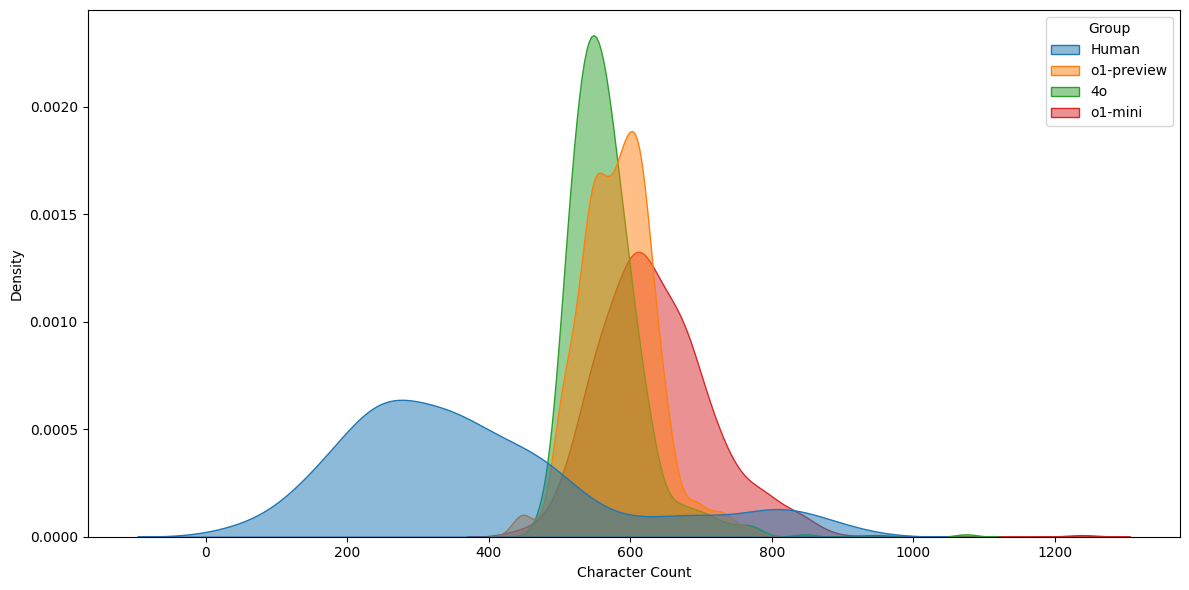

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_expanded, x="Char_Count", hue="Group", fill=True, alpha=0.5)
plt.xlabel("Character Count")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("Character_Count_Density.pdf", format="pdf")
plt.show()

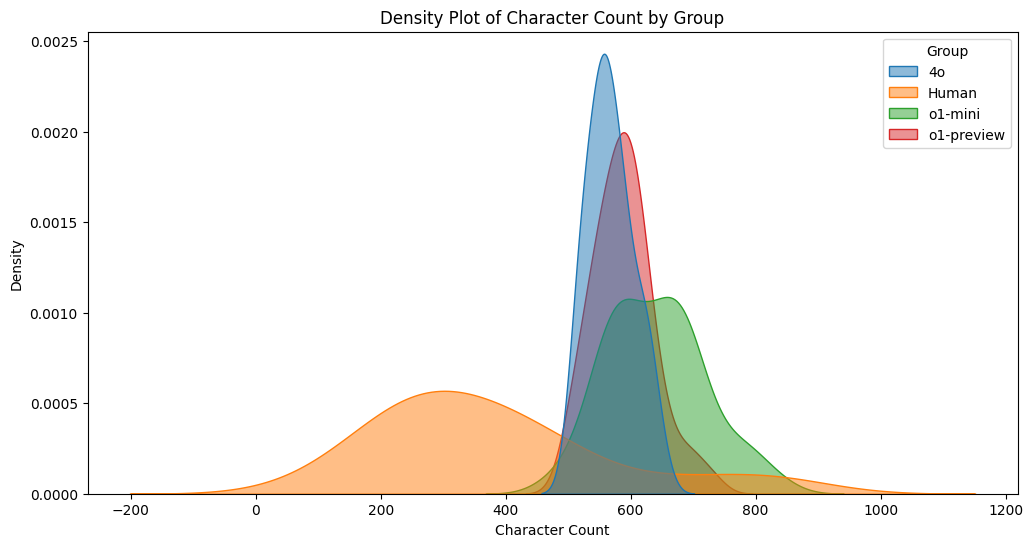

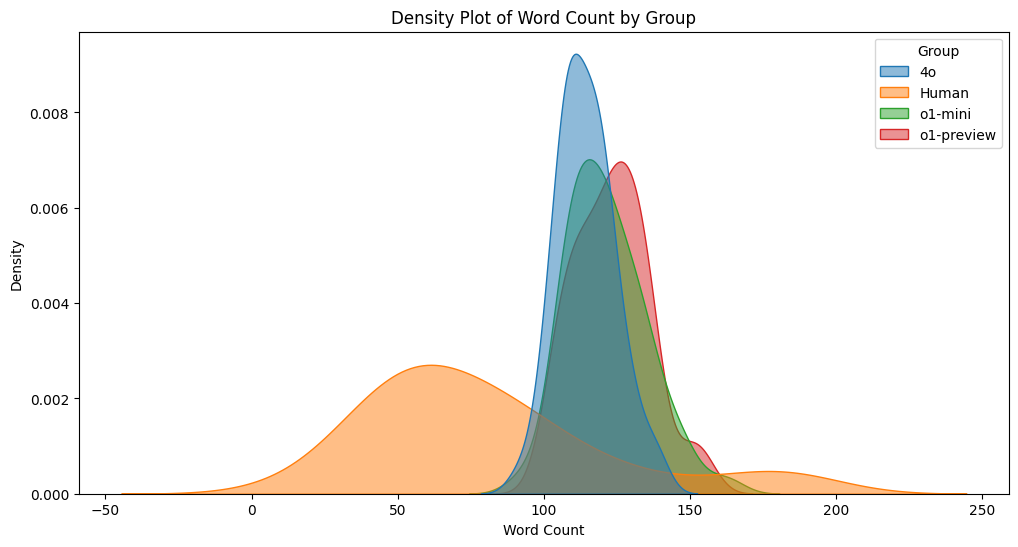

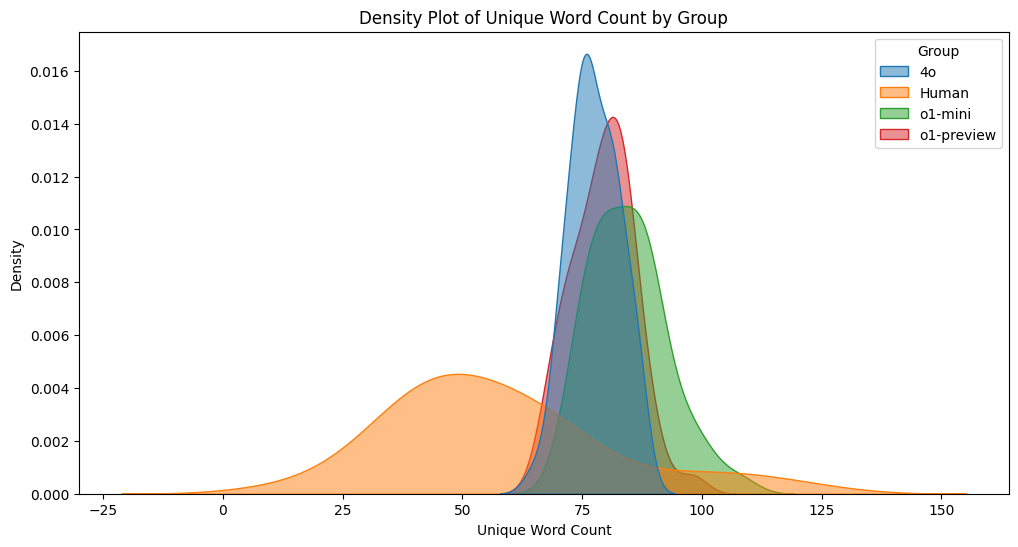

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Char_Count", hue="Group", fill=True, alpha=0.5)
plt.title("Density Plot of Character Count by Group")
plt.xlabel("Character Count")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Word_Count", hue="Group", fill=True, alpha=0.5)
plt.title("Density Plot of Word Count by Group")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Unique_Word_Count", hue="Group", fill=True, alpha=0.5)
plt.title("Density Plot of Unique Word Count by Group")
plt.xlabel("Unique Word Count")
plt.ylabel("Density")
plt.show()

**С удаление стоп слов**

In [ ]:
df["Joke Content Cleaned"] = df["Joke Content"].apply(remove_stopwords)

df["Char_Count"] = df["Joke Content Cleaned"].apply(get_char_count)
df["Word_Count"] = df["Joke Content Cleaned"].apply(get_word_count)
df["Unique_Word_Count"] = df["Joke Content Cleaned"].apply(get_unique_word_count)


In [ ]:
# Рассчитываем суммарные показатели по группам
group_summary = df.groupby("Group").agg(
    Total_Char_Count=("Char_Count", "sum"),
    Total_Word_Count=("Word_Count", "sum"),
    Unique_Words=("Joke Content", lambda texts: len(set(word_tokenize(" ".join(texts).lower()))))
).reset_index()
group_summary["Words_per_Unique_Word"] = group_summary["Total_Word_Count"] / group_summary["Unique_Words"]
group_summary

Group  Total_Char_Count  Total_Word_Count  Unique_Words  \
0          4o             22801              4204          1472   
1       Human             13463              2630          1303   
2     o1-mini             25877              4480          1312   
3  o1-preview             23218              4461          1310   

   Words_per_Unique_Word  
0               2.855978  
1               2.018419  
2               3.414634  
3               3.405344

In [ ]:
group_summary2 = df.groupby("Topic").agg(
    Total_Char_Count=("Char_Count", "sum"),
    Total_Word_Count=("Word_Count", "sum"),
    Unique_Words=("Joke Content", lambda texts: len(set(word_tokenize(" ".join(texts).lower()))))
).reset_index()
group_summary2["Words_per_Unique_Word"] = group_summary2["Total_Word_Count"] / group_summary2["Unique_Words"]
group_summary2

Topic  Total_Char_Count  Total_Word_Count  Unique_Words  \
0    IT             41722              7576          1915   
1     S             43637              8199          2216   

   Words_per_Unique_Word  
0               3.956136  
1               3.699910

In [ ]:
group_stats = df.groupby("Group")["Char_Count"].agg(["mean", "std", "var"]).reset_index()
group_stats.columns = ["Group", "Mean_Char_Count", "Std_Char_Count", "Var_Char_Count"]

group_stats

Group  Mean_Char_Count  Std_Char_Count  Var_Char_Count
0          4o           456.02       33.756928     1139.530204
1       Human           269.26      139.738796    19526.931020
2     o1-mini           517.54       65.208679     4252.171837
3  o1-preview           464.36       47.113740     2219.704490

In [ ]:
group_stats = df.groupby("Group")["Word_Count"].agg(["mean", "std", "var"]).reset_index()
group_stats.columns = ["Group", "Mean_Word_Count", "Std_Word_Count", "Var_Word_Count"]

group_stats

Group  Mean_Word_Count  Std_Word_Count  Var_Word_Count
0          4o            84.08        8.230952       67.748571
1       Human            52.60       29.442438      866.857143
2     o1-mini            89.60       10.575289      111.836735
3  o1-preview            89.22       12.219573      149.317959

In [ ]:
group_stats = df.groupby("Group")["Unique_Word_Count"].agg(["mean", "std", "var"]).reset_index()
group_stats.columns = ["Group", "Mean_Unique_Words", "Std_Unique_Words", "Var_Unique_Words"]

group_stats


Group  Mean_Unique_Words  Std_Unique_Words  Var_Unique_Words
0          4o              61.30          4.656573         21.683673
1       Human              40.90         19.082260        364.132653
2     o1-mini              68.38          7.241857         52.444490
3  o1-preview              62.00          5.649634         31.918367

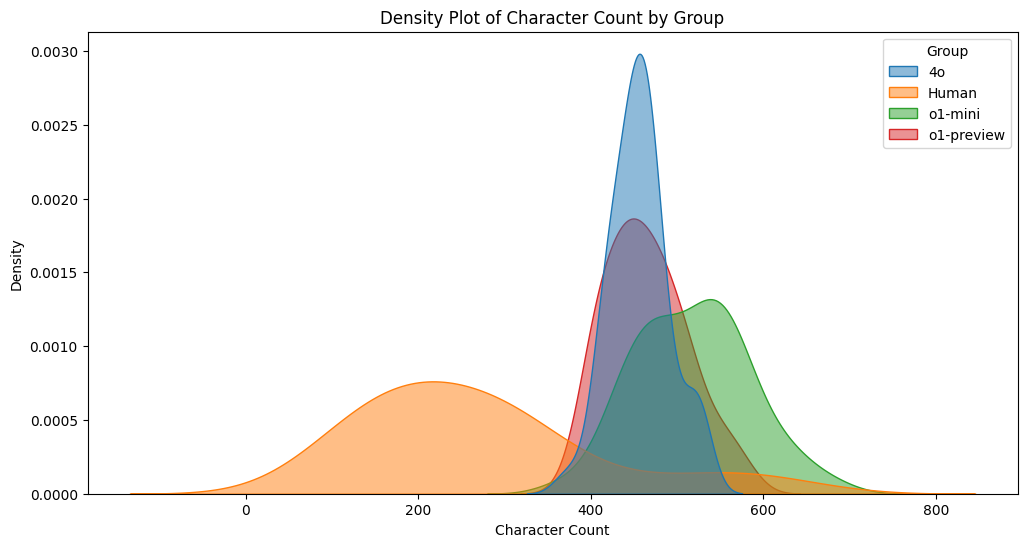

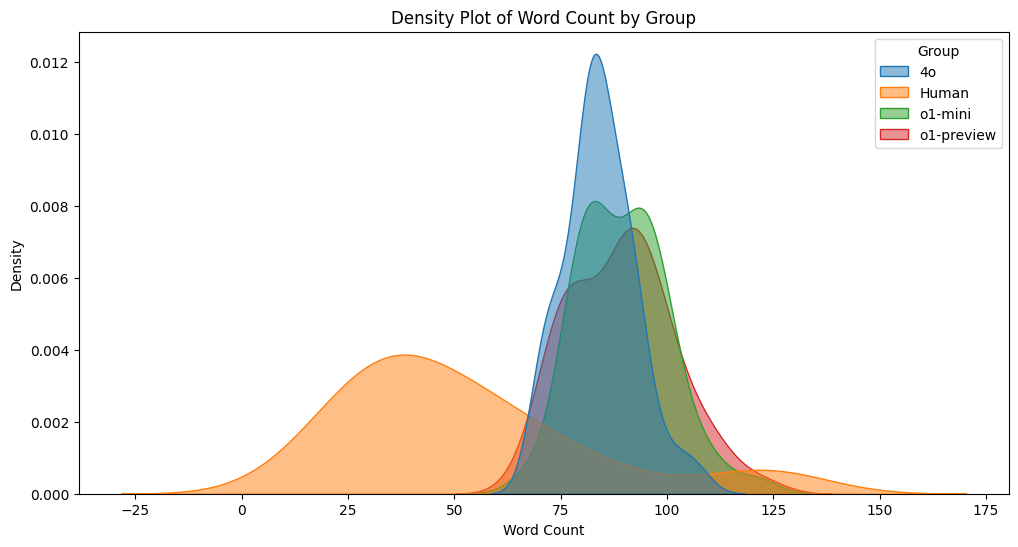

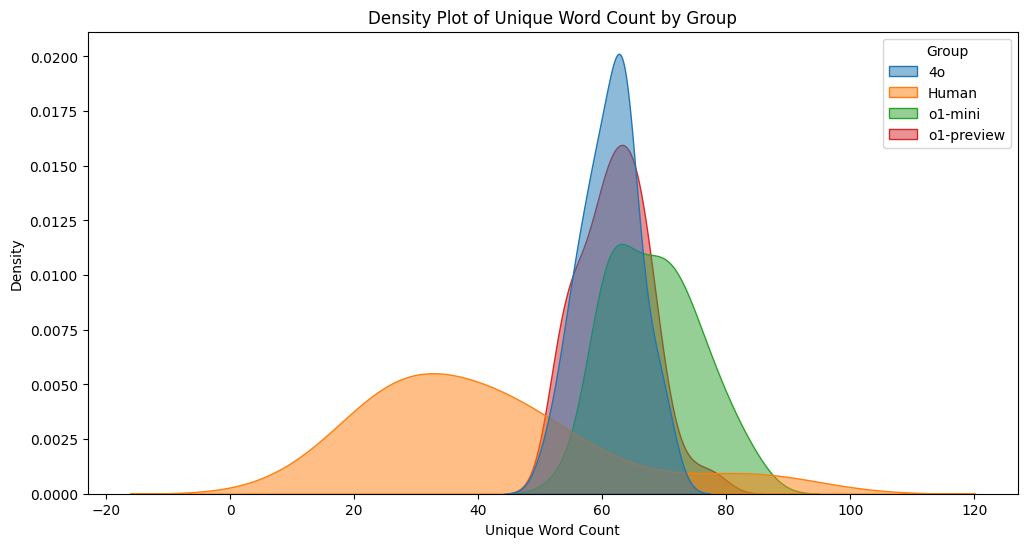

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Char_Count", hue="Group", fill=True, alpha=0.5)
plt.title("Density Plot of Character Count by Group")
plt.xlabel("Character Count")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Word_Count", hue="Group", fill=True, alpha=0.5)
plt.title("Density Plot of Word Count by Group")
plt.xlabel("Word Count")
plt.ylabel("Density")
plt.show()

plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x="Unique_Word_Count", hue="Group", fill=True, alpha=0.5)
plt.title("Density Plot of Unique Word Count by Group")
plt.xlabel("Unique Word Count")
plt.ylabel("Density")
plt.show()


In [ ]:
color_palette = pc.qualitative.color_palette = pc.qualitative.Dark2

subdf_Space = df[df["Topic"] == "S"]

# График количества символов
fig_char = px.line(subdf_Space, x="Joke Number", y="Char_Count", color="Group", markers=True,
                   title="Character Count per Joke Number for Space Jokes", labels={"Char_Count": "Character Count"},
                   color_discrete_sequence=color_palette)
fig_char.show()

# График количества слов
fig_word = px.line(subdf_Space, x="Joke Number", y="Word_Count", color="Group", markers=True,
                   title="Word Count per Joke Number for Space Jokes", labels={"Word_Count": "Word Count"},
                   color_discrete_sequence=color_palette)
fig_word.show()

# График количества уникальных слов
fig_unique_word = px.line(subdf_Space, x="Joke Number", y="Unique_Word_Count", color="Group", markers=True,
                          title="Unique Word Count per Joke Number for Space Jokes", labels={"Unique_Word_Count": "Unique Word Count"},
                          color_discrete_sequence=color_palette)
fig_unique_word.show()

In [ ]:
color_palette = pc.qualitative.color_palette = pc.qualitative.Dark2

subdf_IT = df[df["Topic"] == "IT"]

# График количества символов
fig_char = px.line(subdf_IT, x="Joke Number", y="Char_Count", color="Group", markers=True,
                   title="Character Count per Joke Number for Creatures in IT Jokes", labels={"Char_Count": "Character Count"},
                   color_discrete_sequence=color_palette)
fig_char.show()

# График количества слов
fig_word = px.line(subdf_IT, x="Joke Number", y="Word_Count", color="Group", markers=True,
                   title="Word Count per Joke Number for Creatures in IT Jokes", labels={"Word_Count": "Word Count"},
                   color_discrete_sequence=color_palette)
fig_word.show()

# График количества уникальных слов
fig_unique_word = px.line(subdf_IT, x="Joke Number", y="Unique_Word_Count", color="Group", markers=True,
                          title="Unique Word Count per Joke Number for Creatures in IT Jokes", labels={"Unique_Word_Count": "Unique Word Count"},
                          color_discrete_sequence=color_palette)
fig_unique_word.show()

# Group Comparison with Bootstrap

In [ ]:
from tqdm.notebook import tqdm

bootstrap_results = []

n_bootstrap = 1000
sample_size = 25

groups = df['Group'].unique()
topics = df['Topic'].unique()

for group in groups:
    for topic in topics:
        subset = df[(df['Group'] == group) & (df['Topic'] == topic)]
        if len(subset) < sample_size:
            continue
        for _ in tqdm(range(n_bootstrap)):
            if group == 'Human':
                sample = subset.sample(n=sample_size, replace=False)
            else:
                sample = subset.sample(n=sample_size, replace=True)
            total_chars = sample["Joke Content"].apply(get_char_count).sum()
            total_words = sample["Joke Content"].apply(get_word_count).sum()
            mean_chars = sample["Joke Content"].apply(get_char_count).mean()
            mean_words = sample["Joke Content"].apply(get_word_count).mean()
            std_chars = sample["Joke Content"].apply(get_char_count).std()
            std_words = sample["Joke Content"].apply(get_word_count).std()
            all_words = word_tokenize(" ".join(sample["Joke Content"]).lower())
            unique_words = len(set(all_words))
            words_per_unique = total_words / unique_words if unique_words else 0

            bootstrap_results.append({
                "Group": group,
                "Topic": topic,
                "Mean_Char_Count": mean_chars,
                "Mean_Word_Count": mean_words,
                "Std_Char_Count": std_chars,
                "Std_Word_Count": std_words,
                "Unique_Words": unique_words,
                "Words_per_Unique_Word": words_per_unique
            })

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Unique words как вообще тут считается? Кажется, что странно

In [ ]:
boot_df = pd.DataFrame(bootstrap_results)
boot_df

Group Topic  Mean_Char_Count  Mean_Word_Count  Std_Char_Count  \
0             4o    IT           614.44           125.44       68.477539   
1             4o    IT           574.12           120.56       28.689894   
2             4o    IT           594.08           121.52       47.369927   
3             4o    IT           572.72           117.28       39.956768   
4             4o    IT           604.24           124.20       50.601614   
...          ...   ...              ...              ...             ...   
7995  o1-preview     S           594.00           126.56       38.758870   
7996  o1-preview     S           582.92           122.48       38.416490   
7997  o1-preview     S           590.68           128.24       42.377982   
7998  o1-preview     S           584.04           126.80       43.331551   
7999  o1-preview     S           584.40           125.76       47.299577   

      Std_Word_Count  Unique_Words  Words_per_Unique_Word  
0          68.477539           795               3.944654  
1          28.689894           784               3.844388  
2          47.369927           782               3.884910  
3          39.956768           776               3.778351  
4          50.601614           807               3.847584  
...              ...           ...                    ...  
7995       38.758870           712               4.443820  
7996       38.416490           682               4.489736  
7997       42.377982           722               4.440443  
7998       43.331551           616               5.146104  
7999       47.299577           727               4.324622  

[8000 rows x 8 columns]

In [ ]:
for col in ['Mean_Char_Count', 'Mean_Word_Count', 'Std_Char_Count', 'Std_Word_Count','Words_per_Unique_Word']:
    summary = boot_df.groupby(['Group', 'Topic'])[col].agg([
        'mean',
        'std',
        lambda x: np.percentile(x, 2.5),
        lambda x: np.percentile(x, 97.5)
    ]).rename(columns={
        "<lambda_0>": "CI_low",
        "<lambda_1>": "CI_high"
    })

    summary = summary.reset_index()

    styled_summary_clean = summary.style.background_gradient(cmap='Greens')

    print(col)
    display(styled_summary_clean)
    print()

Mean_Char_Count



Mean_Word_Count



Std_Char_Count



Std_Word_Count



Words_per_Unique_Word


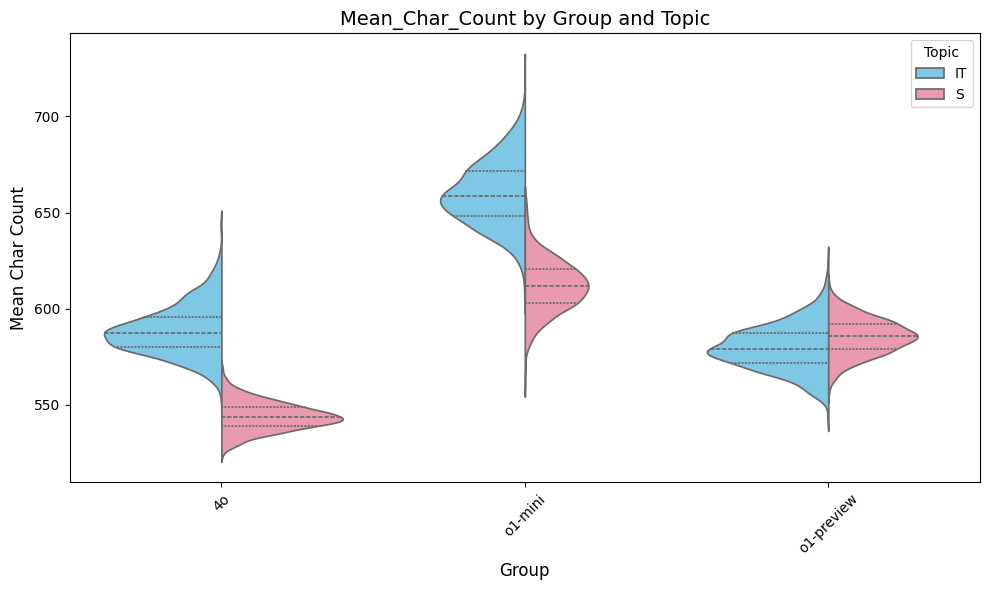

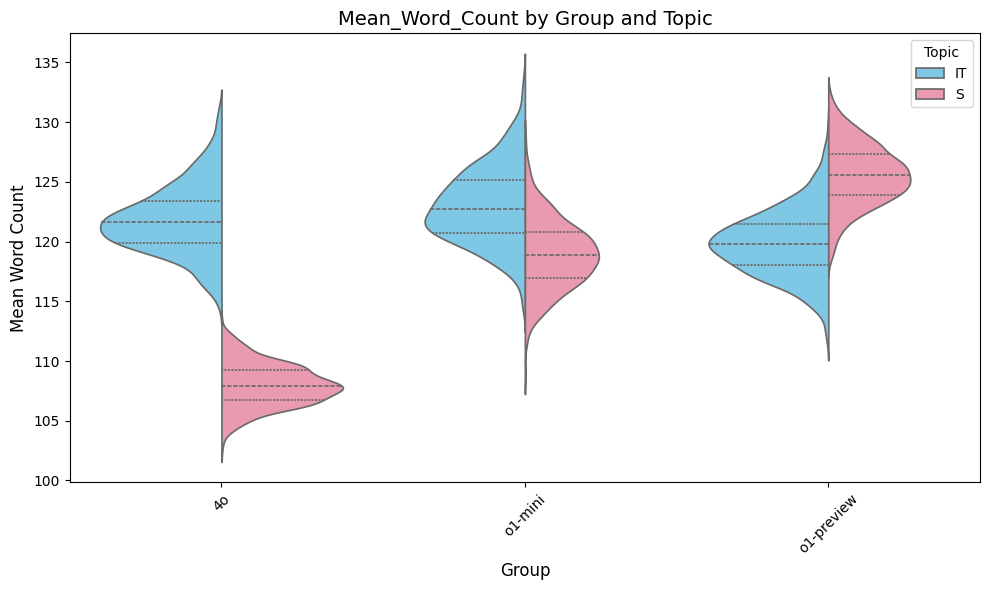

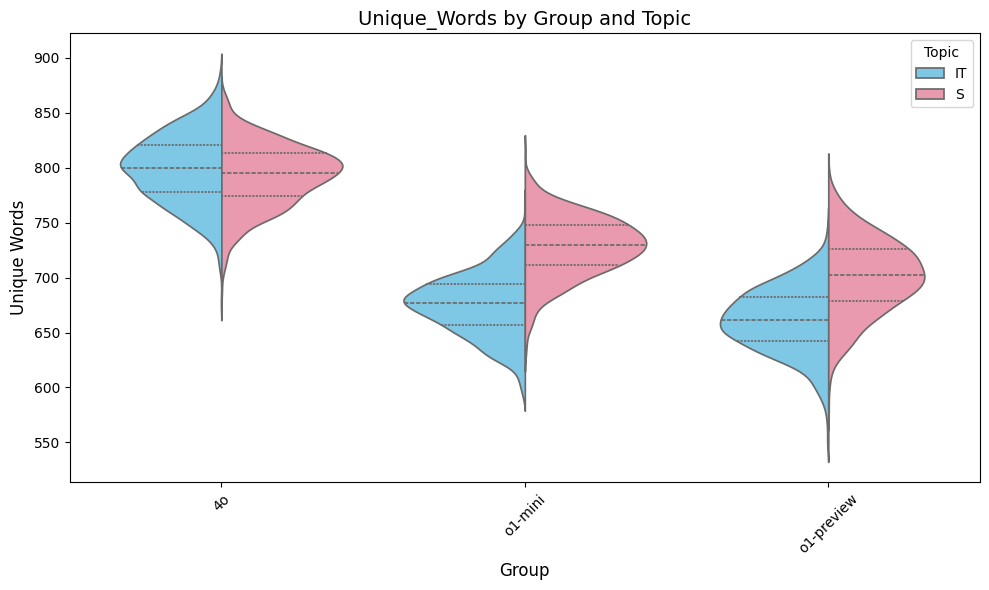

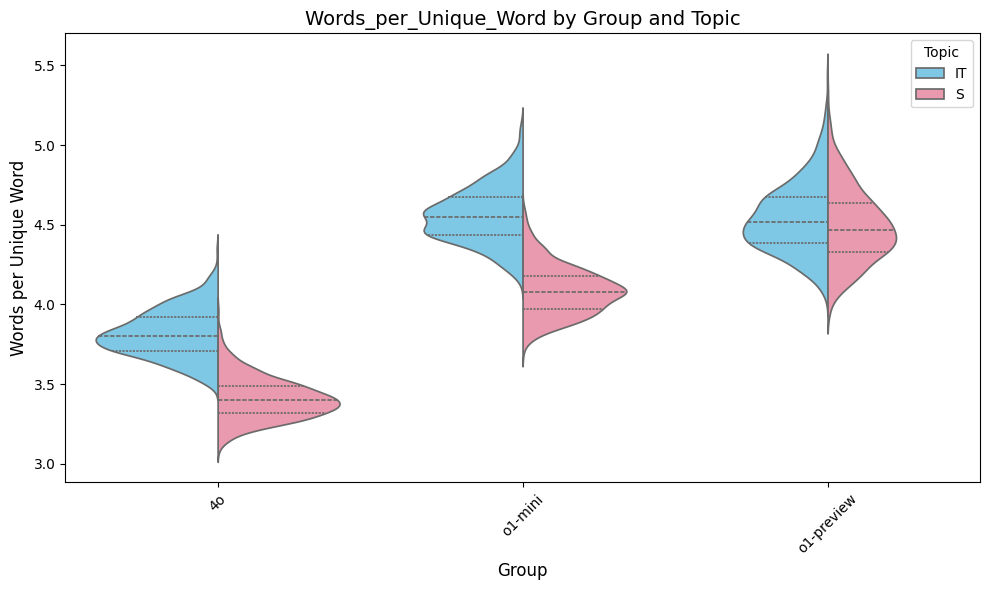

In [ ]:
metrics = ["Mean_Char_Count", "Mean_Word_Count", "Unique_Words", "Words_per_Unique_Word"]

custom_palette = {
    "IT": "#6ECFF6",     # голубой
    "S": "#F78DA7"       # розовый
}

boot_df2 = boot_df[boot_df["Group"] != "Human"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=boot_df2,
        x="Group",
        y=metric,
        hue="Topic",
        palette=custom_palette,
        split=True,
        inner="quartile"
    )
    plt.title(f'{metric} by Group and Topic', fontsize=14)
    plt.xlabel("Group", fontsize=12)
    plt.ylabel(metric.replace("_", " "), fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Topic")
    plt.tight_layout()
    plt.show()

# TF-IDF

In [ ]:
# === TF-IDF анализ ===
vectorizer = TfidfVectorizer(stop_words="english")

tfidf_matrix = vectorizer.fit_transform(df["Joke Content"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_group_entropy = tfidf_df.apply(lambda x: entropy(x + 1e-10), axis=1)

df["TFIDF_Entropy"] = tfidf_group_entropy
entropy_stats = df.groupby(["Topic", "Group"])["TFIDF_Entropy"].agg(["mean", "std"]).reset_index()
entropy_stats.columns = ["Topic", "Group", "Mean_TFIDF_Entropy", "Std_TFIDF_Entropy"]
entropy_stats

Topic       Group  Mean_TFIDF_Entropy  Std_TFIDF_Entropy
0    IT          4o            3.808591           0.124658
1    IT       Human            3.102711           0.478462
2    IT     o1-mini            3.986761           0.117636
3    IT  o1-preview            3.804091           0.117564
4     S          4o            3.754438           0.085351
5     S       Human            3.374859           0.476703
6     S     o1-mini            3.911127           0.116776
7     S  o1-preview            3.751953           0.122130

In [ ]:
# Функция для вычисления TF-IDF и нахождения топ-30 уникальных слов для каждой группы
def get_top_tfidf_words(df, group_column, text_column, top_n=30):
    group_words = {}

    for group, sub_df in df.groupby(group_column):
        vectorizer = TfidfVectorizer(stop_words="english", max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(sub_df[text_column])
        feature_names = vectorizer.get_feature_names_out()

        # Средний TF-IDF по каждому слову
        mean_tfidf = tfidf_matrix.mean(axis=0).A1
        word_tfidf = dict(zip(feature_names, mean_tfidf))

        # Сортируем и берем топ-N слов
        top_words = sorted(word_tfidf.items(), key=lambda x: x[1], reverse=True)[:top_n]
        group_words[group] = [word for word, score in top_words]

    return group_words

# Вычисляем топ-30 TF-IDF слов для каждой группы
top_words_by_group = get_top_tfidf_words(df, "Group", "Joke Content", top_n=30)

# Функция для нахождения уникальных слов в каждой группе (по сравнению с другими)
def get_unique_words(top_words_by_group):
    unique_words = {}

    all_words = set(word for words in top_words_by_group.values() for word in words)

    for group, words in top_words_by_group.items():
        other_words = set(all_words) - set(words)
        unique_words[group] = [word for word in words if word not in other_words]

    return unique_words

# Получаем уникальные слова для каждой группы
unique_words_by_group = get_unique_words(top_words_by_group)
unique_words_by_group = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in unique_words_by_group.items()]))
unique_words_by_group["Top Rank"] = np.arange(1, 31)
unique_words_by_group

4o       Human      o1-mini o1-preview  Top Rank
0        cosmic        just       cosmic     dragon         1
1        dragon        need          zog     cosmic         2
2       unicorn          ve     universe    unicorn         3
3           zog        know          day   universe         4
4      universe        time         team      quark         5
5         named        like       dragon       tech         6
6          just       space    creatures       just         7
7       captain       earth        elara        day         8
8        server         got     suddenly      magic         9
9           day       alien      handled     wizard        10
10  existential        says         void     nebula        11
11        space    computer       nebula        zog        12
12        black        code        magic      space        13
13       nebula     finally      captain    laughed        14
14      centaur  apparently    absurdity       code        15
15       quasar         don         luna      named        16
16         hole         say       horror    captain        17
17        troll         did      proving   suddenly        18
18     suddenly     cthulhu  existential     worked        19
19         tech      office    existence      troll        20
20     chuckled      planet    enchanted   firewall        21
21         byte      dragon        draco   mythical        22
22     bustling        life      unicorn     server        23
23     pondered       today         just      squid        24
24         code      aliens      network      asked        25
25     sentient  completely      magical     sighed        26
26    creatures         new         code  existence        27
27     firewall      flying      laughed        elf        28
28       office       years      servers   chuckled        29
29      laughed          ll          elf  realizing        30

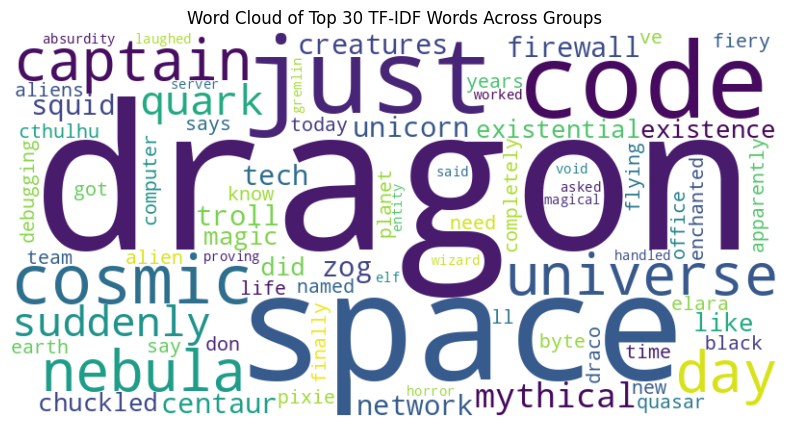

In [ ]:
# Генерация облака слов для всех групп
all_top_words = [word for words in top_words_by_group.values() for word in words]
word_freq = Counter(all_top_words)

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(word_freq)

# Отображаем облако слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Top 30 TF-IDF Words Across Groups")
plt.show()

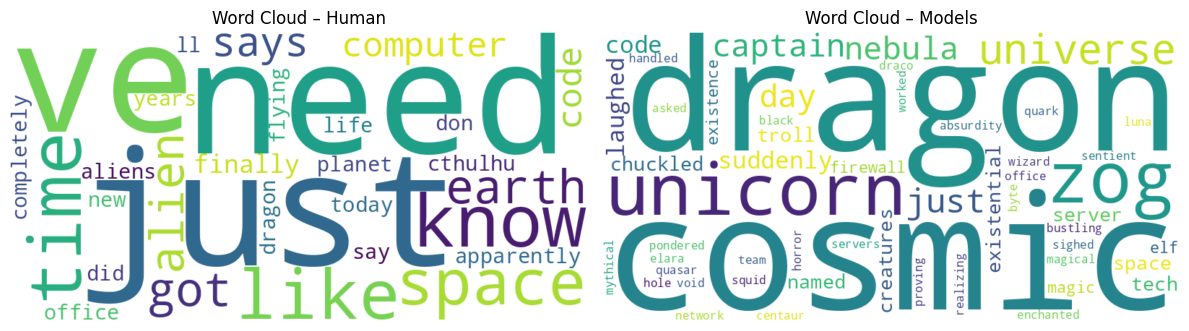

In [ ]:
human_words = [word for word in top_words_by_group["Human"]]
human_freq = Counter(human_words)
wordcloud_human = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(human_freq)

non_human_words = [word for group, words in top_words_by_group.items() if group != "Human" for word in words]
non_human_freq = Counter(non_human_words)
wordcloud_non_human = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(non_human_freq)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_human, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Human")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_human, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Models")

plt.tight_layout()
plt.savefig("Creativity_2.pdf", format="pdf")
plt.show()

In [ ]:
# Энтропия распределения частот слов
def shannon_entropy(text):
    words = word_tokenize(text.lower())
    word_freq = nltk.FreqDist(words)
    probs = np.array(list(word_freq.values())) / sum(word_freq.values())
    return entropy(probs, base=2)

In [ ]:
df["Word_Freq_Entropy"] = df["Joke Content"].apply(shannon_entropy)
entropy_stats = df.groupby("Group")["Word_Freq_Entropy"].agg(["mean", "std"]).reset_index()
entropy_stats.columns = ["Group", "Mean_Entropy", "Std_Entropy"]
entropy_stats

Group  Mean_Entropy  Std_Entropy
0          4o      5.883344     0.124845
1       Human      5.524580     0.549360
2     o1-mini      6.013846     0.132009
3  o1-preview      5.881257     0.147896

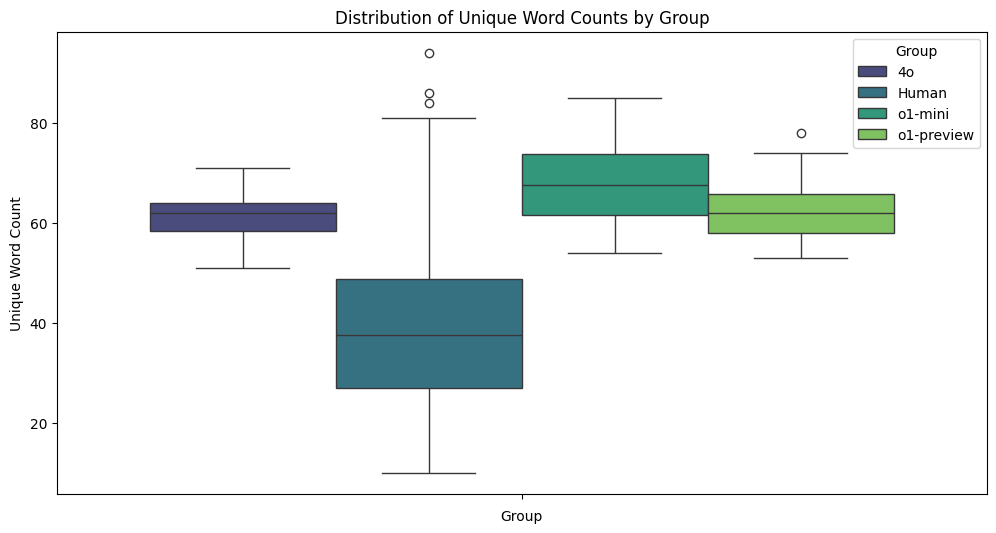

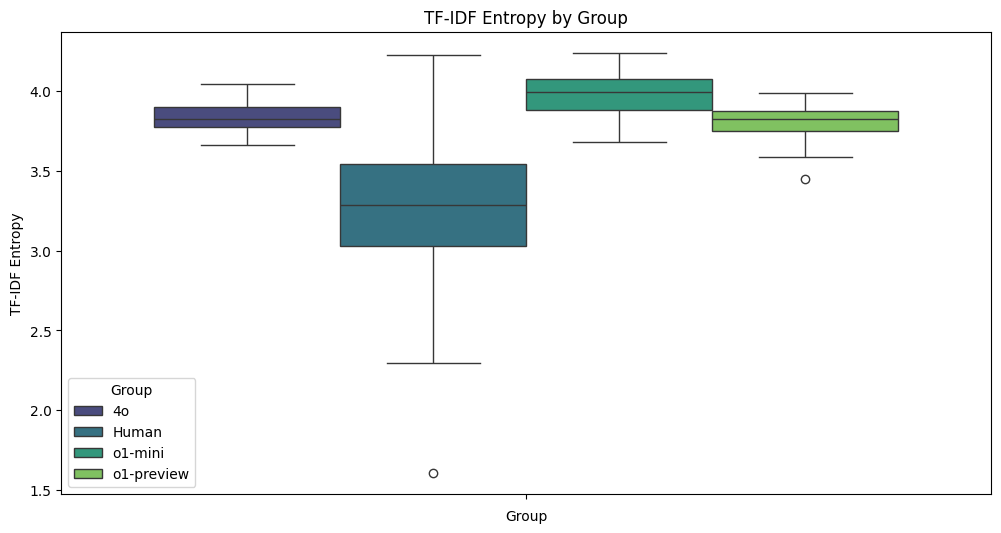

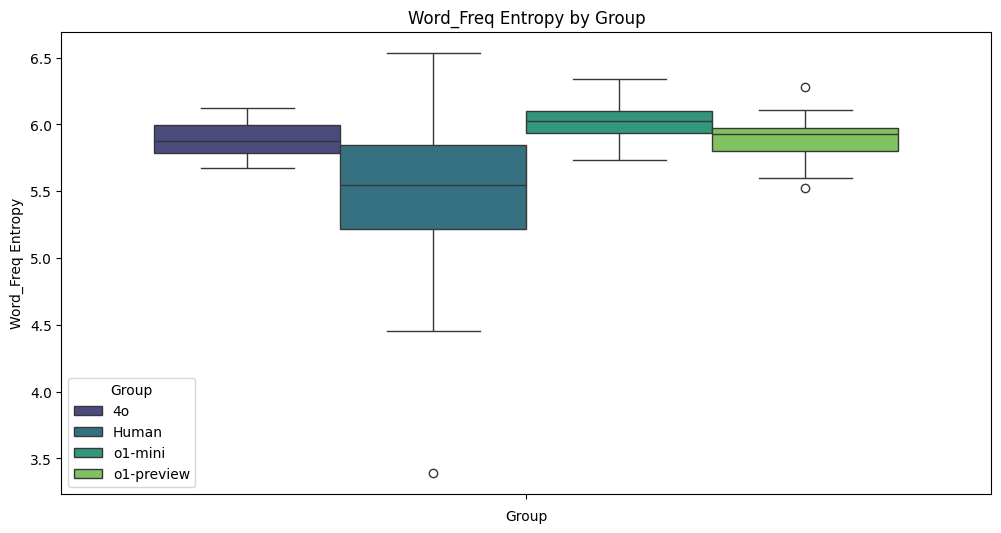

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(hue="Group", y="Unique_Word_Count", data=df, palette="viridis")
plt.title("Distribution of Unique Word Counts by Group")
plt.xlabel("Group")
plt.ylabel("Unique Word Count")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(hue="Group", y="TFIDF_Entropy", data=df, palette="viridis")
plt.title("TF-IDF Entropy by Group")
plt.xlabel("Group")
plt.ylabel("TF-IDF Entropy")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(hue="Group", y="Word_Freq_Entropy", data=df, palette="viridis")
plt.title("Word_Freq Entropy by Group")
plt.xlabel("Group")
plt.ylabel("Word_Freq Entropy")
plt.xticks(rotation=45)
plt.show()


Тесты на сравнения?

# Embeddings

In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
model.encode(df.iloc[0]["Joke Content"]).shape

(768,)

In [8]:
# Вычисляем эмбеддинги для всех анекдотов
df["Embeddings"] = df["Joke Content"].apply(lambda x: model.encode(x, convert_to_numpy=True))

In [9]:
# Функция для расчета средней косинусной разницы внутри группы
def compute_avg_cosine_distance(embeddings):
    distances = cosine_distances(embeddings)
    return np.mean(distances)

# Функция для расчета дисперсии эмбеддингов
def compute_embedding_variance(embeddings):
    return np.var(embeddings, axis=0).mean()

# Функция для вычисления энтропии распределения расстояний
def compute_entropy(embeddings):
    distances = cosine_distances(embeddings).flatten()
    return entropy(distances, base=2)

In [13]:
# Группировка по модели, способу генерации, и теме
group_analysis = []
for (topic, group), sub_df in df.groupby(["Topic", "Group"]):
    embeddings = np.vstack(sub_df["Embeddings"].values)

    avg_cosine_distance = compute_avg_cosine_distance(embeddings)

    group_analysis.append([topic, group, avg_cosine_distance])

group_analysis_df = pd.DataFrame(group_analysis, columns=["Topic", "Group", "Avg_Cosine_Distance"])
group_analysis_df

Topic       Group  Avg_Cosine_Distance
0    IT          4o             0.321674
1    IT       Human             0.755266
2    IT     o1-mini             0.207066
3    IT  o1-preview             0.298253
4     S          4o             0.345885
5     S       Human             0.732460
6     S     o1-mini             0.267932
7     S  o1-preview             0.316893

In [20]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances
from tqdm.notebook import tqdm

def compute_avg_cosine_distance(embeddings):
    distances = cosine_distances(embeddings)
    return np.mean(distances)

def compute_bootstrap_avg_distance(embeddings, n_iterations=1000, sample_size=25):
    avg_distances = []
    for _ in tqdm(range(n_iterations)):
        sample_indices = np.random.choice(len(embeddings), size=sample_size, replace=True)
        sample = embeddings[sample_indices]
        avg_distances.append(compute_avg_cosine_distance(sample))
    return np.mean(avg_distances)

group_analysis = []

for (topic, group), sub_df in df.groupby(["Topic", "Group"]):
    embeddings = np.vstack(sub_df["Embeddings"].values)

    if group == "Human":
        avg_cosine_distance = compute_avg_cosine_distance(embeddings)
    else:
        if len(embeddings) >= 2:
            avg_cosine_distance = compute_bootstrap_avg_distance(embeddings)
        else:
            avg_cosine_distance = np.nan

    group_analysis.append([topic, group, avg_cosine_distance])

group_analysis_df = pd.DataFrame(group_analysis, columns=["Topic", "Group", "Avg_Cosine_Distance"])
group_analysis_df


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Topic       Group  Avg_Cosine_Distance
0    IT          4o             0.308689
1    IT       Human             0.755266
2    IT     o1-mini             0.198349
3    IT  o1-preview             0.286170
4     S          4o             0.332190
5     S       Human             0.732460
6     S     o1-mini             0.257107
7     S  o1-preview             0.304512

In [ ]:
# Группировка по модели и способу генерации
group_analysis = []
for group, sub_df in df.groupby("Group"):
    embeddings = np.vstack(sub_df["Embeddings"].values)

    avg_cosine_distance = compute_avg_cosine_distance(embeddings)
    embedding_variance = compute_embedding_variance(embeddings)
    entropy_value = compute_entropy(embeddings)

    group_analysis.append([group, avg_cosine_distance, embedding_variance, entropy_value])

group_analysis_df = pd.DataFrame(group_analysis, columns=["Group", "Avg_Cosine_Distance", "Embedding_Variance", "Entropy"])
group_analysis_df


Group  Avg_Cosine_Distance  Embedding_Variance    Entropy
0          4o             0.521328            0.000679  11.124113
1       Human             0.825841            0.001075  11.241495
2     o1-mini             0.493708            0.000643  11.028692
3  o1-preview             0.530962            0.000691  11.108600

In [ ]:
# Группировка по модели, способу генерации, и теме
group_analysis = []
for (topic, group), sub_df in df.groupby(["Topic", "Group"]):
    embeddings = np.vstack(sub_df["Embeddings"].values)

    avg_cosine_distance = compute_avg_cosine_distance(embeddings)
    embedding_variance = compute_embedding_variance(embeddings)
    entropy_value = compute_entropy(embeddings)

    group_analysis.append([topic, group, avg_cosine_distance, embedding_variance, entropy_value])

group_analysis_df = pd.DataFrame(group_analysis, columns=["Topic", "Group", "Avg_Cosine_Distance", "Embedding_Variance", "Entropy"])
group_analysis_df

Topic       Group  Avg_Cosine_Distance  Embedding_Variance   Entropy
0    IT          4o             0.303777            0.000396  9.201696
1    IT       Human             0.755266            0.000983  9.213923
2    IT     o1-mini             0.202929            0.000264  9.172351
3    IT  o1-preview             0.275851            0.000359  9.180298
4     S          4o             0.295061            0.000384  9.202329
5     S       Human             0.732460            0.000954  9.203160
6     S     o1-mini             0.245461            0.000320  9.170743
7     S  o1-preview             0.317604            0.000414  9.188952

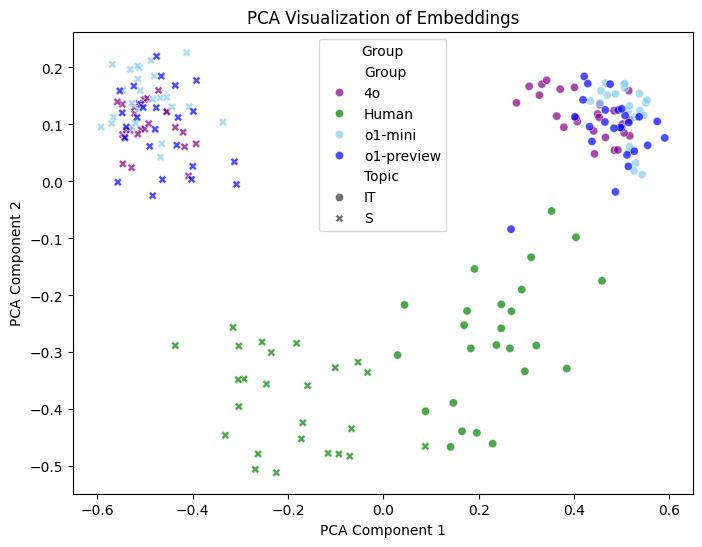

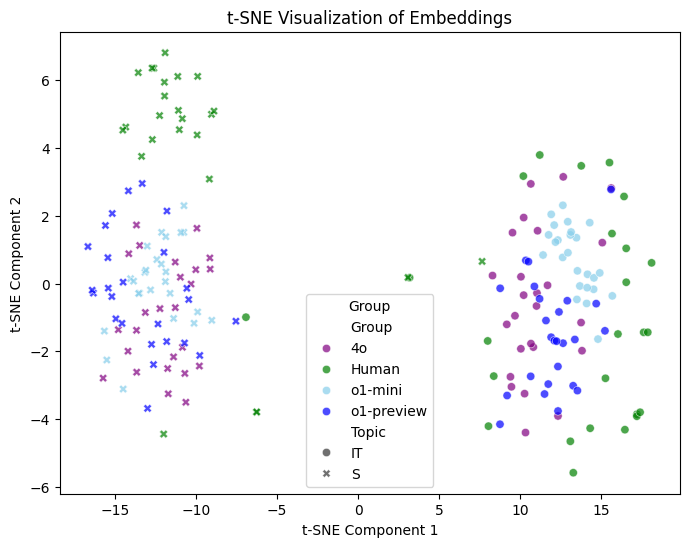

In [ ]:
# PCA и t-SNE для визуализации
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

df["PCA_Embeddings"] = list(pca.fit_transform(np.vstack(df["Embeddings"].values)))
df["TSNE_Embeddings"] = list(tsne.fit_transform(np.vstack(df["Embeddings"].values)))

custom_palette = {
    "Human": "green",
    "o1-preview": "blue",
    "o1-mini": "skyblue",
    "4o": "purple"
}

pca_data = np.array(df["PCA_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_data[:, 0], y=pca_data[:, 1],
    hue=df["Group"], style=df["Topic"],
    palette=custom_palette, alpha=0.7
)
plt.title("PCA Visualization of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Group")
plt.show()

tsne_data = np.array(df["TSNE_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_data[:, 0], y=tsne_data[:, 1],
    hue=df["Group"], style=df["Topic"],
    palette=custom_palette, alpha=0.7
)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Group")
plt.show()

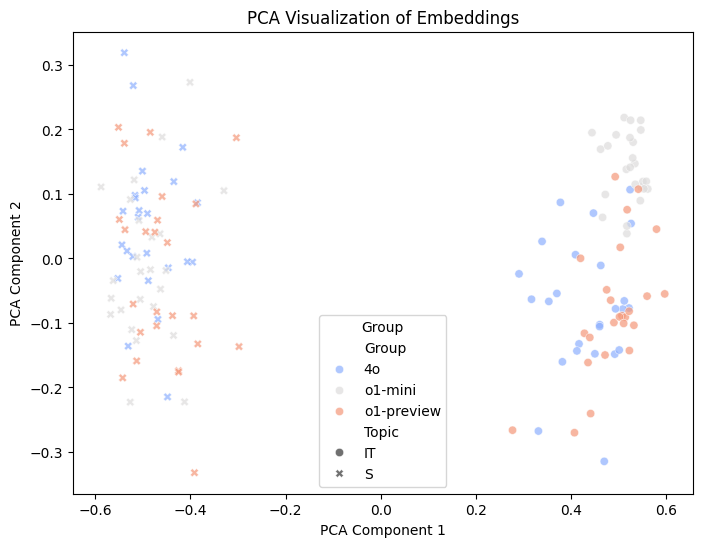

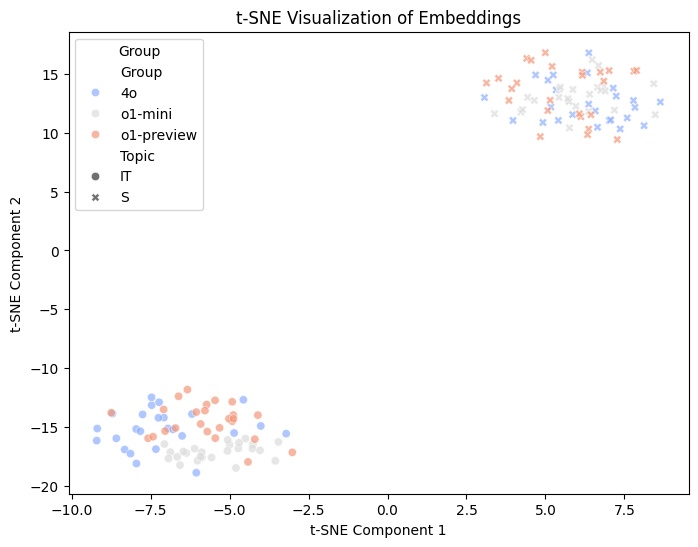

In [ ]:
# PCA и t-SNE для визуализации
df_graph = df[df["Group"] != "Human"].copy()

pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

df_graph["PCA_Embeddings"] = list(pca.fit_transform(np.vstack(df_graph["Embeddings"].values)))
df_graph["TSNE_Embeddings"] = list(tsne.fit_transform(np.vstack(df_graph["Embeddings"].values)))


pca_data = np.array(df_graph["PCA_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_data[:, 0], y=pca_data[:, 1],
    hue=df_graph["Group"], style=df_graph["Topic"],
    palette='coolwarm', alpha=0.7
)
plt.title("PCA Visualization of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Group")
plt.show()

tsne_data = np.array(df_graph["TSNE_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_data[:, 0], y=tsne_data[:, 1],
    hue=df_graph["Group"], style=df_graph["Topic"],
    palette='coolwarm', alpha=0.7
)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Group")
plt.show()

In [ ]:
# Функция для нахождения всех пар шуток с максимальным сходством в группе
def find_all_similar_jokes(group_df):
    embeddings = np.vstack(group_df["Embeddings"].values)  # Преобразуем в матрицу
    similarity_matrix = cosine_similarity(embeddings)  # Считаем косинусное сходство

    # Заполняем диагональ (сходство с собой) нулями, чтобы не учитывать их
    np.fill_diagonal(similarity_matrix, 0)

    # Сортируем пары по убыванию схожести
    pairs = []
    for i in range(len(group_df)):
        for j in range(i + 1, len(group_df)):
            pairs.append((i, j, similarity_matrix[i, j]))

    # Отбираем топ-5 самых похожих пар в группе
    top_pairs = sorted(pairs, key=lambda x: x[2], reverse=True)[:5]

    # Формируем список строк с шутками и их схожестью
    similar_pairs = [
        {
            "Group": group_df.iloc[i]["Group"],
            "Similarity Score": sim_score,
            "Joke 1": group_df.iloc[i]["Joke Content"],
            "Joke 2": group_df.iloc[j]["Joke Content"],
        }
        for i, j, sim_score in top_pairs
    ]

    return similar_pairs

all_similar_jokes = []
for group, group_df in df.groupby("Group"):
    all_similar_jokes.extend(find_all_similar_jokes(group_df))

all_similar_jokes_df = pd.DataFrame(all_similar_jokes)
all_similar_jokes_df


Group  Similarity Score  \
0           4o          0.839027   
1           4o          0.831777   
2           4o          0.827384   
3           4o          0.819215   
4           4o          0.817666   
5        Human          0.595448   
6        Human          0.583699   
7        Human          0.563648   
8        Human          0.562333   
9        Human          0.561866   
10     o1-mini          0.912183   
11     o1-mini          0.896760   
12     o1-mini          0.896615   
13     o1-mini          0.896399   
14     o1-mini          0.895837   
15  o1-preview          0.863243   
16  o1-preview          0.859423   
17  o1-preview          0.853613   
18  o1-preview          0.848932   
19  o1-preview          0.848119   

                                               Joke 1  \
0   In the mystical realm of Byteborough, dragons,...   
1   Captain Zog piloted the cosmic jellybean, Hype...   
2   In an IT office nestled in a magical forest, a...   
3   In an IT office nestled in a magical forest, a...   
4   Captain Zog piloted the cosmic jellybean, Hype...   
5   Lieutenant Flint shed a single tear inside his...   
6   In the year 5319, NASA astronaut Charlton John...   
7   A group of elves stand outside an emergency do...   
8   Two cosmonauts blast off into space, venturing...   
9   Two cosmonauts blast off into space, venturing...   
10  In the whimsical realm of ByteLand, fantastic ...   
11  At MythicTech, the IT department was anything ...   
12  Captain Nebula stared into the swirling cosmic...   
13  In the enchanted realm of Bytewood, mythical c...   
14  In the enchanted kingdom of ByteLand, mythical...   
15  In a mythical tech startup, a dragon, a unicor...   
16  In a mystical tech startup, a wizard, a dragon...   
17  Captain Quark piloted his ship into the heart ...   
18  In a mythical tech startup, a dragon was the h...   
19  Captain Zog gazed into the abyss of the cosmos...   

                                               Joke 2  
0   In a bustling IT firm in the land of Mythosvil...  
1   In the infinite silence of space, Captain Zog ...  
2   In a bustling IT office hidden beneath the Enc...  
3   In a bustling IT office in the enchanted fores...  
4   Captain Zog, a sentient blob, piloted the USS ...  
5   After spending 10 years in the vast emptiness ...  
6   NASA astronaut Paul Ritchson ran through his f...  
7   A pair of managers are flying all over the cit...  
8   Two astronauts sit down at a bar. The bartende...  
9   Many tales are told of the brave men, women, a...  
10  In the enchanted kingdom of ByteLand, mythical...  
11  At MythicTech Inc., the IT department was anyt...  
12  In the infinite void, Captain Zorg and his cre...  
13  In the enchanted land of Bytewood, the IT depa...  
14  In the enchanted land of Bytewood, a team of f...  
15  In a mythical tech startup, a dragon was the h...  
16  In a mythical tech startup, a dragon was the h...  
17  In the farthest reaches of the cosmos, Captain...  
18  In a magical tech startup, a dragon, a unicorn...  
19  In the furthest reaches of the galaxy, Command...

In [ ]:
pair = all_similar_jokes_df.iloc[0]

print("Joke 1:")
print("\n".join(textwrap.wrap(pair["Joke 1"], width=100)))
print("\nJoke 2:")
print("\n".join(textwrap.wrap(pair["Joke 2"], width=100)))

Joke 1:
In the mystical realm of Byteborough, dragons, unicorns, and trolls unexpectedly found themselves
working at a tech startup called Enchanted Tech. The dragons, notorious for their fiery tempers,
were placed in charge of security, though their firewall was a bit too literal. Unicorns handled
cloud services, but clients complained the rainbows messed up the bandwidth. Meanwhile, the trolls
became tech support—every complaint was met with, "Have you tried crossing the bridge?" Despite the
chaos, they unanimously agreed: nothing was scarier than debugging.

Joke 2:
In a bustling IT firm in the land of Mythosville, dragons, unicorns, and trolls were hard at work.
The dragons handled security because, after all, who'd dare hack a system with a fire-breathing
firewall? The unicorns, operational support, magically turned rare bugs into features with their
horns. Meanwhile, a troll applied for a networking position but got stuck in data traffic,
grumbling, “Seems I’ve finally met my ban

In [ ]:
pair = all_similar_jokes_df.iloc[7]

print("Joke 1:")
print("\n".join(textwrap.wrap(pair["Joke 1"], width=100)))
print("\nJoke 2:")
print("\n".join(textwrap.wrap(pair["Joke 2"], width=100)))

Joke 1:
A group of elves stand outside an emergency door in knee-deep snow. They’re all chain  smoking
cigarettes and scrolling through social media on their cell phones.   One turns to the others and
says “200 years ago when I got into this business, it was  mostly to build wooden toy trains and
rocking chairs. Who knew Steve Jobs would drop  the iPhone and we’d become Santa’s IT department?!”

Joke 2:
A pair of managers are flying all over the city on the back of a dragon. The dragon,  enraged, is
destroying everything in sight, and breathing fire on nearby buildings,  causing a mass panic. One
manager sees a group of civilians on the ground, and  shouts “Help! We’re trying to get this dragon
out of here but we don’t even know where  we are!”   One of the civilians, an elf, looks up and
shouts “I can tell you exactly where you are.  You’re on a dragon, that’s where!” The managers both
facepalm. One turns to the other  and says “we must be flying over the server building. Only an IT
t

**! Смотрим на все шутки**

In [ ]:
df = pd.read_csv("All_Jokes_API.csv")
df = df.drop(columns=["Temperature"])
df["Embeddings"] = df["Joke Content"].apply(lambda x: model.encode(x, convert_to_numpy=True))

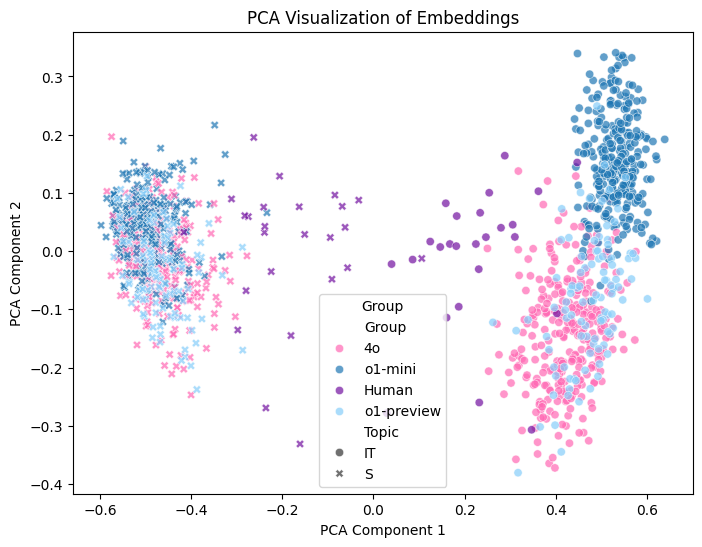

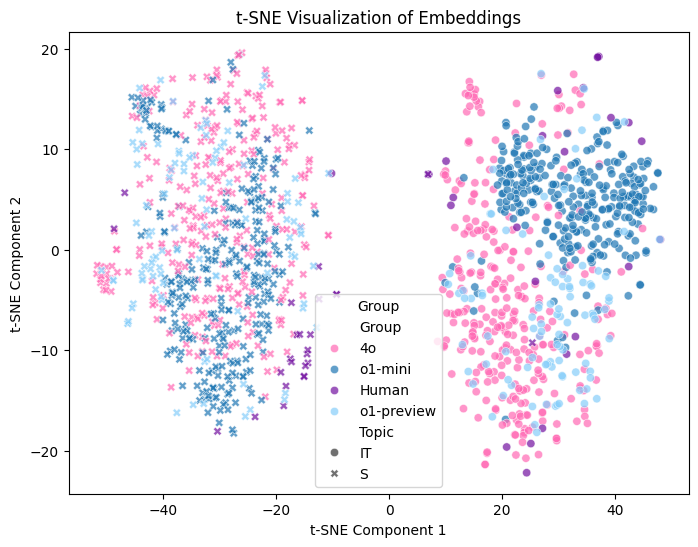

In [ ]:
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

df["PCA_Embeddings"] = list(pca.fit_transform(np.vstack(df["Embeddings"].values)))
df["TSNE_Embeddings"] = list(tsne.fit_transform(np.vstack(df["Embeddings"].values)))

custom_palette = {
    "Human": '#7311a0',
    "o1-preview": '#87CEFA',
    "o1-mini": '#1f77b4',
    "4o": '#FF69B4'
}

pca_data = np.array(df["PCA_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_data[:, 0], y=pca_data[:, 1],
    hue=df["Group"], style=df["Topic"],
    palette=custom_palette, alpha=0.7
)
plt.title("PCA Visualization of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Group")
plt.show()

tsne_data = np.array(df["TSNE_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_data[:, 0], y=tsne_data[:, 1],
    hue=df["Group"], style=df["Topic"],
    palette=custom_palette, alpha=0.7
)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Group")
plt.show()

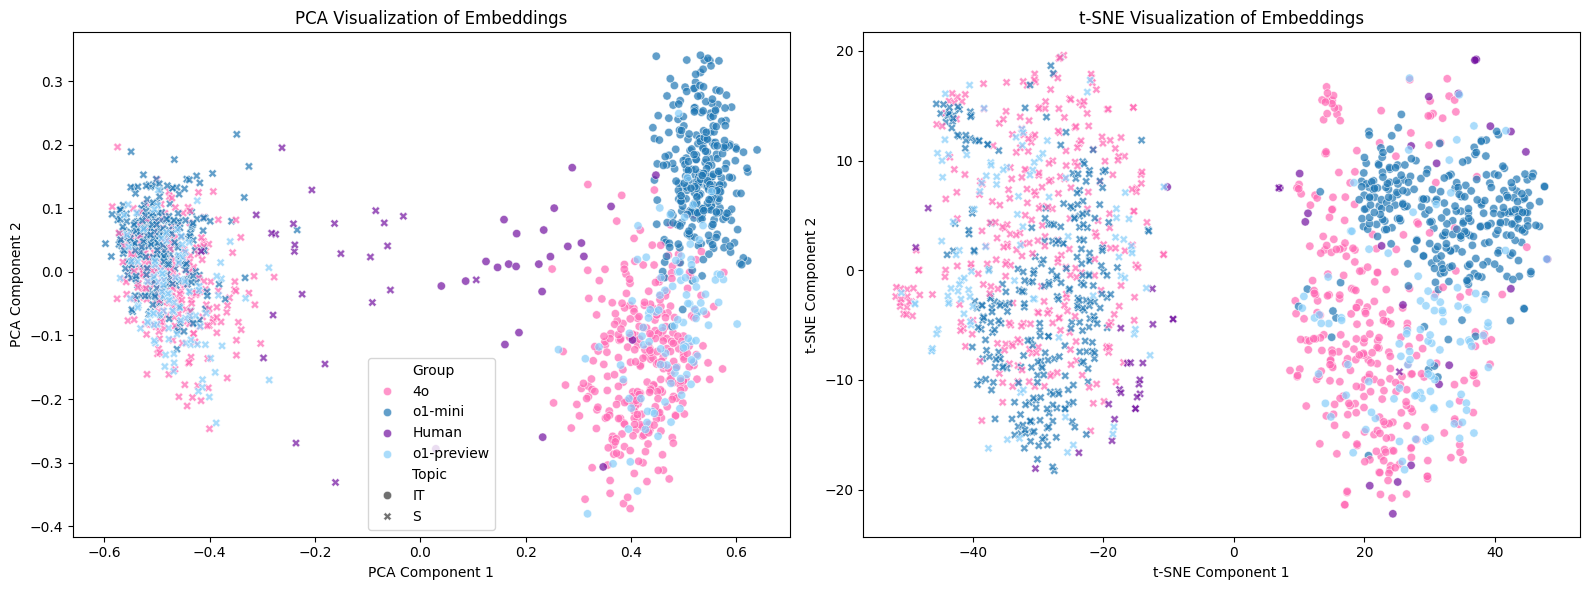

In [ ]:
# PCA и t-SNE преобразования
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

df["PCA_Embeddings"] = list(pca.fit_transform(np.vstack(df["Embeddings"].values)))
df["TSNE_Embeddings"] = list(tsne.fit_transform(np.vstack(df["Embeddings"].values)))

custom_palette = {
    "Human": '#7311a0',
    "o1-preview": '#87CEFA',
    "o1-mini": '#1f77b4',
    "4o": '#FF69B4'
}

# Визуализация: PCA и t-SNE рядом
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# PCA
pca_data = np.array(df["PCA_Embeddings"].tolist())
sns.scatterplot(
    ax=axs[0],
    x=pca_data[:, 0], y=pca_data[:, 1],
    hue=df["Group"], style=df["Topic"],
    palette=custom_palette, alpha=0.7
)
axs[0].set_title("PCA Visualization of Embeddings")
axs[0].set_xlabel("PCA Component 1")
axs[0].set_ylabel("PCA Component 2")

# t-SNE
tsne_data = np.array(df["TSNE_Embeddings"].tolist())
sns.scatterplot(
    ax=axs[1],
    x=tsne_data[:, 0], y=tsne_data[:, 1],
    hue=df["Group"], style=df["Topic"],
    palette=custom_palette, alpha=0.7,
    legend=False  # Чтобы не дублировать легенду
)
axs[1].set_title("t-SNE Visualization of Embeddings")
axs[1].set_xlabel("t-SNE Component 1")
axs[1].set_ylabel("t-SNE Component 2")

# Настройка и сохранение
plt.tight_layout()
plt.savefig("Creativity_3.pdf", format="pdf")
plt.show()

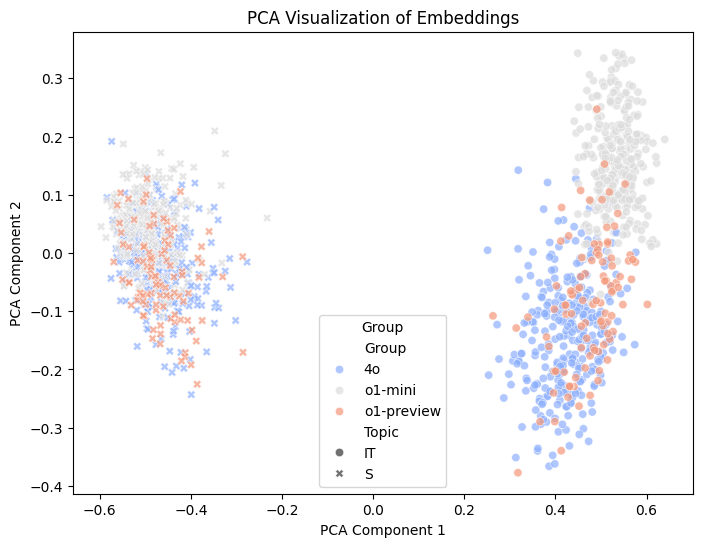

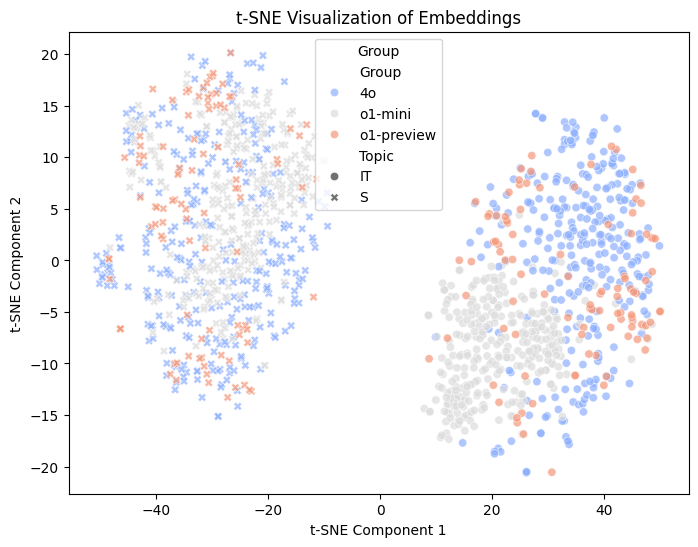

In [ ]:
# PCA и t-SNE для визуализации
df_graph = df[df["Group"] != "Human"].copy()

pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)

df_graph["PCA_Embeddings"] = list(pca.fit_transform(np.vstack(df_graph["Embeddings"].values)))
df_graph["TSNE_Embeddings"] = list(tsne.fit_transform(np.vstack(df_graph["Embeddings"].values)))


pca_data = np.array(df_graph["PCA_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=pca_data[:, 0], y=pca_data[:, 1],
    hue=df_graph["Group"], style=df_graph["Topic"],
    palette='coolwarm', alpha=0.7
)
plt.title("PCA Visualization of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Group")
plt.show()

tsne_data = np.array(df_graph["TSNE_Embeddings"].tolist())
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=tsne_data[:, 0], y=tsne_data[:, 1],
    hue=df_graph["Group"], style=df_graph["Topic"],
    palette='coolwarm', alpha=0.7
)
plt.title("t-SNE Visualization of Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Group")
plt.show()

In [ ]:
df["Joke Content Cleaned"] = df["Joke Content"].apply(remove_stopwords)

df["Char_Count"] = df["Joke Content Cleaned"].apply(get_char_count)
df["Word_Count"] = df["Joke Content Cleaned"].apply(get_word_count)
df["Unique_Word_Count"] = df["Joke Content Cleaned"].apply(get_unique_word_count)


In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
tfidf_matrix = vectorizer.fit_transform(df["Joke Content"])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_group_entropy = tfidf_df.apply(lambda x: entropy(x + 1e-10), axis=1)

df["TFIDF_Entropy"] = tfidf_group_entropy
df["Word_Freq_Entropy"] = df["Joke Content"].apply(shannon_entropy)
df

Joke Number                                       Joke Content  \
0               1  In the mythical lands of TechTopia, an IT depa...   
1               2  In the bustling IT department of Mythical Ente...   
2               3  In the bustling land of Techtopia, a grumpy dr...   
3               4  In the magical IT department of Fantasia Corp,...   
4               5  In a bustling IT office, a griffin, a unicorn,...   
...           ...                                                ...   
1445           96  In the depths of space, astronaut Zara encount...   
1446           97  In the vast expanse of space, astronaut Zed fl...   
1447           98  Captain Zogg piloted his starship into the hea...   
1448           99  In the vast abyss of space, a cosmic jellyfish...   
1449          100  In the depths of space, Captain Nebula met a s...   

           Group Topic                                         Embeddings  \
0             4o    IT  [0.0036222304, 0.00936651, -0.01764886, 0.0238...   
1             4o    IT  [0.027781865, 0.046091527, -0.021511806, 0.004...   
2             4o    IT  [0.0016672909, 0.052032348, -0.011978956, -0.0...   
3             4o    IT  [0.043501183, 0.031559017, -0.022587745, 0.028...   
4             4o    IT  [0.026997874, 0.028978929, -0.039107878, 0.012...   
...          ...   ...                                                ...   
1445  o1-preview     S  [0.03115099, -0.0041423817, -0.015026018, 0.02...   
1446  o1-preview     S  [0.027619312, -0.03255569, 0.0017487118, -0.05...   
1447  o1-preview     S  [0.039007902, 0.007316371, 0.012766118, -0.026...   
1448  o1-preview     S  [0.086029425, -0.028927578, -0.02368098, -0.01...   
1449  o1-preview     S  [0.019722832, -0.027495116, -0.003420459, -0.0...   

                                   Joke Content Cleaned  Char_Count  \
0     mythical lands TechTopia, department run team ...         443   
1     bustling department Mythical Enterprises, team...         451   
2     bustling land Techtopia, grumpy dragon named S...         434   
3     magical department Fantasia Corp, unicorns cha...         472   
4     bustling office, griffin, unicorn, dragon work...         438   
...                                                 ...         ...   
1445  depths space, astronaut Zara encountered colos...         400   
1446  vast expanse space, astronaut Zed floated alon...         429   
1447  Captain Zogg piloted starship heart black hole...         423   
1448  vast abyss space, cosmic jellyfish named Blorp...         510   
1449  depths space, Captain Nebula met sentient blac...         531   

      Word_Count  Unique_Word_Count  TFIDF_Entropy  Word_Freq_Entropy  
0             82                 60       3.776763           5.945326  
1             76                 60       3.802986           5.979508  
2             86                 62       3.752821           5.978026  
3             71                 56       3.844585           5.852547  
4            101                 61       3.635011           5.737172  
...          ...                ...            ...                ...  
1445          80                 52       3.606356           5.713965  
1446          92                 58       3.623156           5.730988  
1447          95                 60       3.618781           5.674665  
1448         106                 64       3.746492           5.694330  
1449         124                 70       3.836348           5.709530  

[1450 rows x 11 columns]

# POS tagging

In [ ]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [ ]:
def pos_tag_text(text):
    words = nltk.word_tokenize(text)  # Токенизация
    pos_tags = nltk.pos_tag(words)  # POS-теггинг
    return [tag for _, tag in pos_tags]  # Возвращаем только теги

df["POS_Tags"] = df["Joke Content"].apply(pos_tag_text)

pos_counts_by_group = {}
for group in df["Group"].unique():
    all_tags = sum(df[df["Group"] == group]["POS_Tags"], [])
    pos_counts_by_group[group] = Counter(all_tags)

pos_df = pd.DataFrame(pos_counts_by_group).fillna(0).astype(int)
pos_df = pos_df.div(pos_df.sum(axis=0), axis=1)  # Нормализация в доли

In [ ]:
# Создаем словарь расшифровок тегов POS
pos_descriptions = {
    "NNP": "Proper Noun (Singular)",
    "NNPS": "Proper Noun (Plural)",
    "NN": "Noun (Singular or Mass)",
    "NNS": "Noun (Plural)",
    "VB": "Verb (Base Form)",
    "VBD": "Verb (Past Tense)",
    "VBG": "Verb (Gerund/Present Participle)",
    "VBN": "Verb (Past Participle)",
    "VBP": "Verb (Non-3rd Person Singular Present)",
    "VBZ": "Verb (3rd Person Singular Present)",
    "JJ": "Adjective",
    "JJR": "Adjective (Comparative)",
    "JJS": "Adjective (Superlative)",
    "RB": "Adverb",
    "RBR": "Adverb (Comparative)",
    "RBS": "Adverb (Superlative)",
    "DT": "Determiner",
    "IN": "Preposition/Subordinating Conjunction",
    "CC": "Coordinating Conjunction",
    "PRP": "Personal Pronoun",
    "PRP$": "Possessive Pronoun",
    "WP": "Wh-Pronoun",
    "WP$": "Possessive Wh-Pronoun",
    "WRB": "Wh-Adverb",
    "MD": "Modal Verb",
    "TO": "'to' as Preposition/Infinitive Marker",
    "EX": "Existential 'there'",
    "CD": "Cardinal Number",
    "PDT": "Predeterminer",
    "POS": "Possessive Ending",
    "UH": "Interjection",
    ".": "Sentence Terminator",
    ",": "Comma",
    ":": "Colon/Semicolon",
    "''": "Closing Quote",
    "``": "Opening Quote",
    "FW": "Foreign Word",
    "#": "Symbol Hash",
    "$": "Currency Symbol",
    "(": "Left Parenthesis",
    ")": "Right Parenthesis",
    "RP": "Particle",
    "WDT": "Wh-Determiner"
}

# Заменяем сокращения POS на их описания
pos_df_readable = pos_df.rename(index=pos_descriptions).dropna()

pos_df_readable

4o   o1-mini     Human  \
Preposition/Subordinating Conjunction   0.078426  0.078155  0.104467   
Determiner                              0.103814  0.103238  0.085856   
Adjective                               0.064180  0.077715  0.071712   
Noun (Plural)                           0.034324  0.051819  0.047643   
Proper Noun (Singular)                  0.073479  0.091558  0.052109   
Comma                                   0.093920  0.080621  0.045161   
Noun (Singular or Mass)                 0.161016  0.172082  0.152357   
Verb (Past Tense)                       0.070012  0.076943  0.039206   
Verb (Past Participle)                  0.017467  0.008265  0.012407   
Sentence Terminator                     0.059784  0.060772  0.056079   
Wh-Pronoun                              0.003714  0.001102  0.002730   
Modal Verb                              0.003728  0.002879  0.007940   
Verb (Base Form)                        0.015784  0.022590  0.036725   
Possessive Pronoun                      0.012375  0.014876  0.019603   
Adverb                                  0.037516  0.033995  0.044665   
Verb (Gerund/Present Participle)        0.025852  0.038017  0.018362   
Cardinal Number                         0.005382  0.005207  0.011663   
Wh-Adverb                               0.005368  0.003692  0.004467   
Opening Quote                           0.020919  0.003320  0.000000   
Closing Quote                           0.021326  0.003416  0.000000   
'to' as Preposition/Infinitive Marker   0.008240  0.009174  0.023325   
Personal Pronoun                        0.028463  0.016860  0.061787   
Adjective (Superlative)                 0.001755  0.001515  0.002730   
Colon/Semicolon                         0.004294  0.002011  0.001985   
Verb (3rd Person Singular Present)      0.009009  0.009367  0.027543   
Coordinating Conjunction                0.014986  0.015234  0.024318   
Verb (Non-3rd Person Singular Present)  0.010228  0.008099  0.029529   
Possessive Ending                       0.005092  0.000868  0.000000   
Adjective (Comparative)                 0.000870  0.000344  0.000496   
Particle                                0.003453  0.002273  0.004963   
Existential 'there'                     0.001088  0.000372  0.000993   
Foreign Word                            0.000522  0.001185  0.000248   
Adverb (Superlative)                    0.000189  0.000152  0.000248   
Interjection                            0.000624  0.000083  0.000744   
Possessive Wh-Pronoun                   0.000203  0.000014  0.000000   
Wh-Determiner                           0.001001  0.001143  0.001985   
Left Parenthesis                        0.000160  0.000096  0.000000   
Right Parenthesis                       0.000160  0.000096  0.000000   
Predeterminer                           0.000479  0.000468  0.002233   
Adverb (Comparative)                    0.000522  0.000262  0.000744   
Proper Noun (Plural)                    0.000247  0.000110  0.000993   
Symbol Hash                             0.000029  0.000000  0.000993   
Currency Symbol                         0.000000  0.000014  0.000993   

                                        o1-preview  
Preposition/Subordinating Conjunction     0.076006  
Determiner                                0.107474  
Adjective                                 0.054307  
Noun (Plural)                             0.033708  
Proper Noun (Singular)                    0.049463  
Comma                                     0.077675  
Noun (Singular or Mass)                   0.156530  
Verb (Past Tense)                         0.079140  
Verb (Past Participle)                    0.015999  
Sentence Terminator                       0.075476  
Wh-Pronoun                                0.004967  
Modal Verb                                0.004356  
Verb (Base Form)                          0.014574  
Possessive Pronoun                        0.010666  
Adverb                                    0.039204  
Verb (Gerund/Present Particip

In [ ]:
pos_df_readable = pos_df_readable[["Human", "4o", "o1-preview", "o1-mini"]]

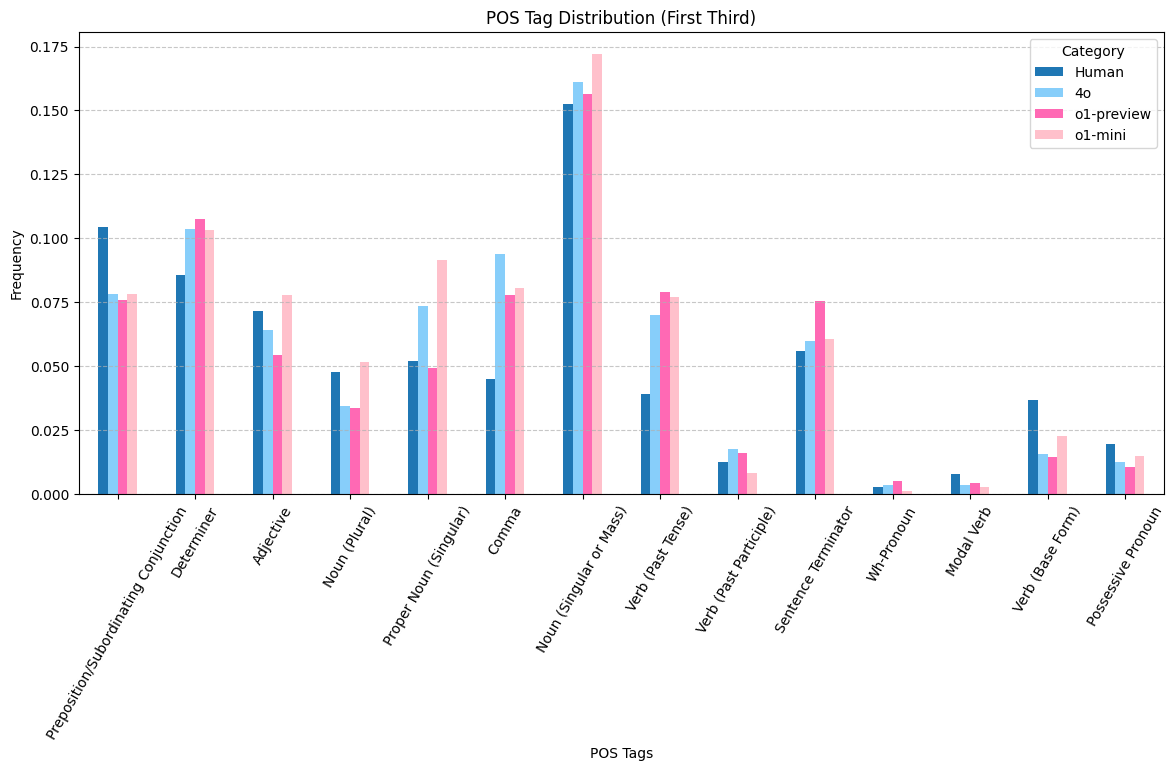

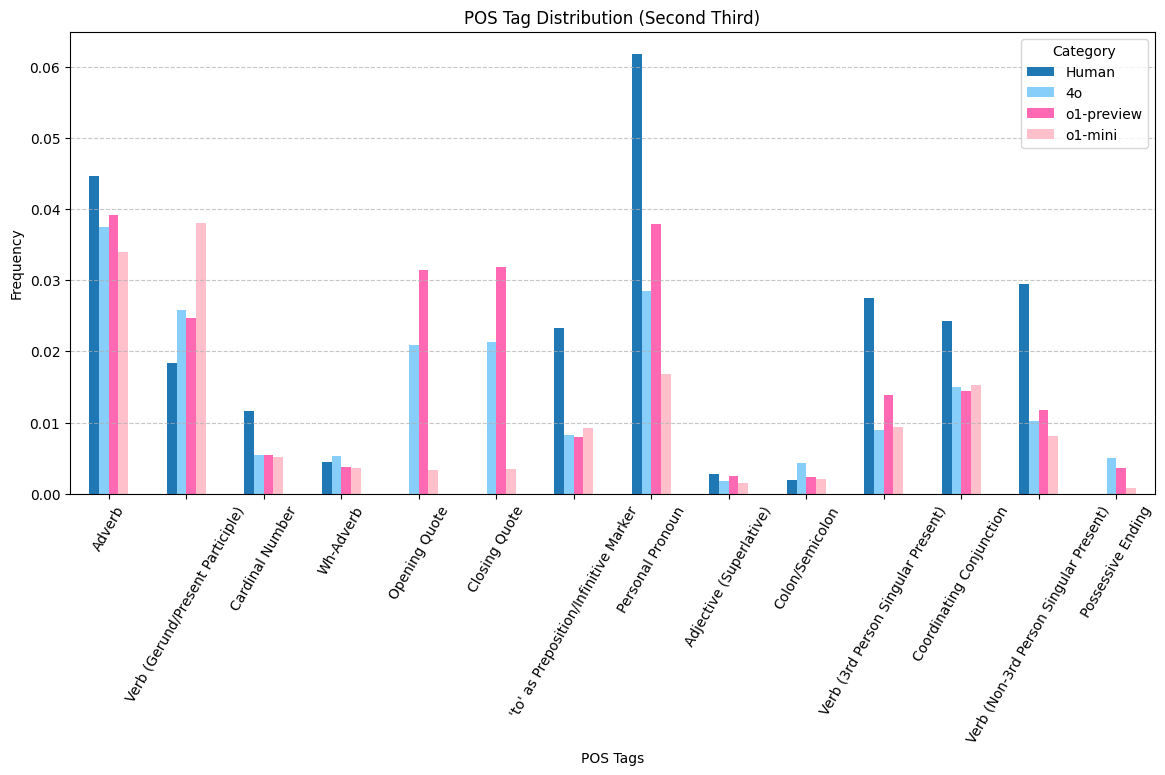

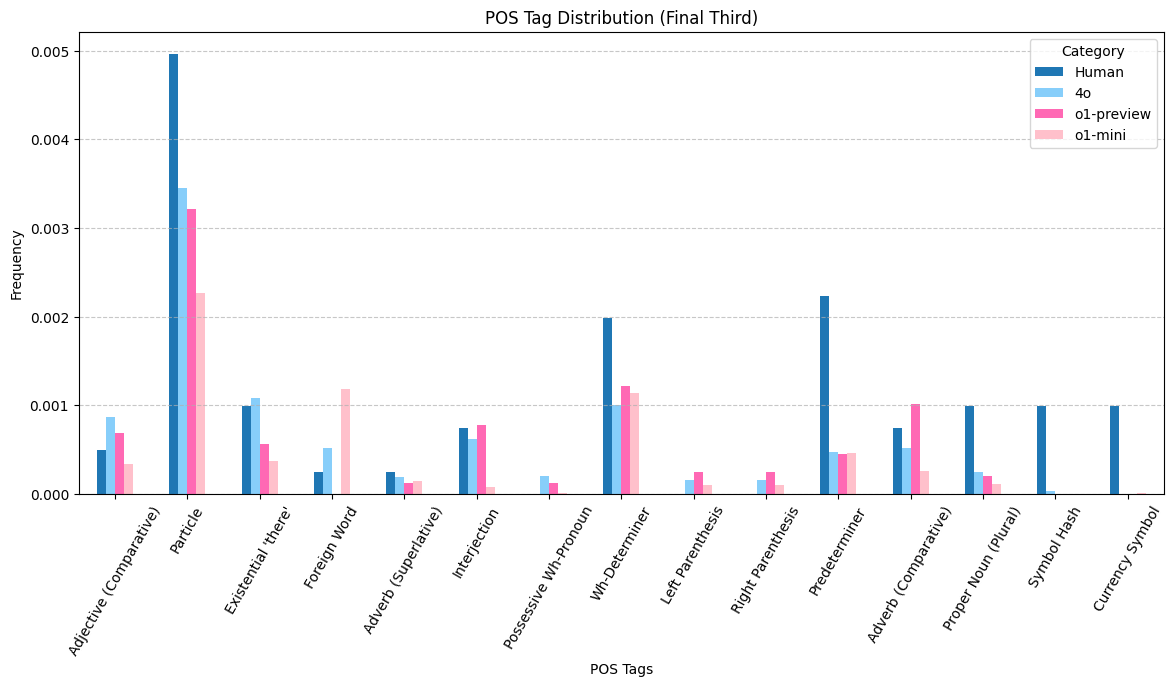

In [ ]:
colors_updated = {
    'Human': '#1f77b4',
    '4o': '#87CEFA',
    'o1-mini': '#FFC0CB',
    'o1-preview': '#FF69B4'
}

df_readable = pos_df_readable

split_1 = len(df_readable) // 3
split_2 = 2 * len(df_readable) // 3

df_first = df_readable.iloc[:split_1]
df_second = df_readable.iloc[split_1:split_2]
df_third = df_readable.iloc[split_2:]

fig, ax1 = plt.subplots(figsize=(14, 6))
df_first.plot(kind='bar', ax=ax1, color=[colors_updated.get(col, 'gray') for col in df_readable.columns])
ax1.set_title("POS Tag Distribution (First Third)")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("POS Tags")
ax1.set_xticklabels(df_first.index, rotation=60)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(title="Category")

fig, ax2 = plt.subplots(figsize=(14, 6))
df_second.plot(kind='bar', ax=ax2, color=[colors_updated.get(col, 'gray') for col in df_readable.columns])
ax2.set_title("POS Tag Distribution (Second Third)")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("POS Tags")
ax2.set_xticklabels(df_second.index, rotation=60)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(title="Category")

fig, ax3 = plt.subplots(figsize=(14, 6))
df_third.plot(kind='bar', ax=ax3, color=[colors_updated.get(col, 'gray') for col in df_readable.columns])
ax3.set_title("POS Tag Distribution (Final Third)")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("POS Tags")
ax3.set_xticklabels(df_third.index, rotation=60)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.legend(title="Category")

plt.show()


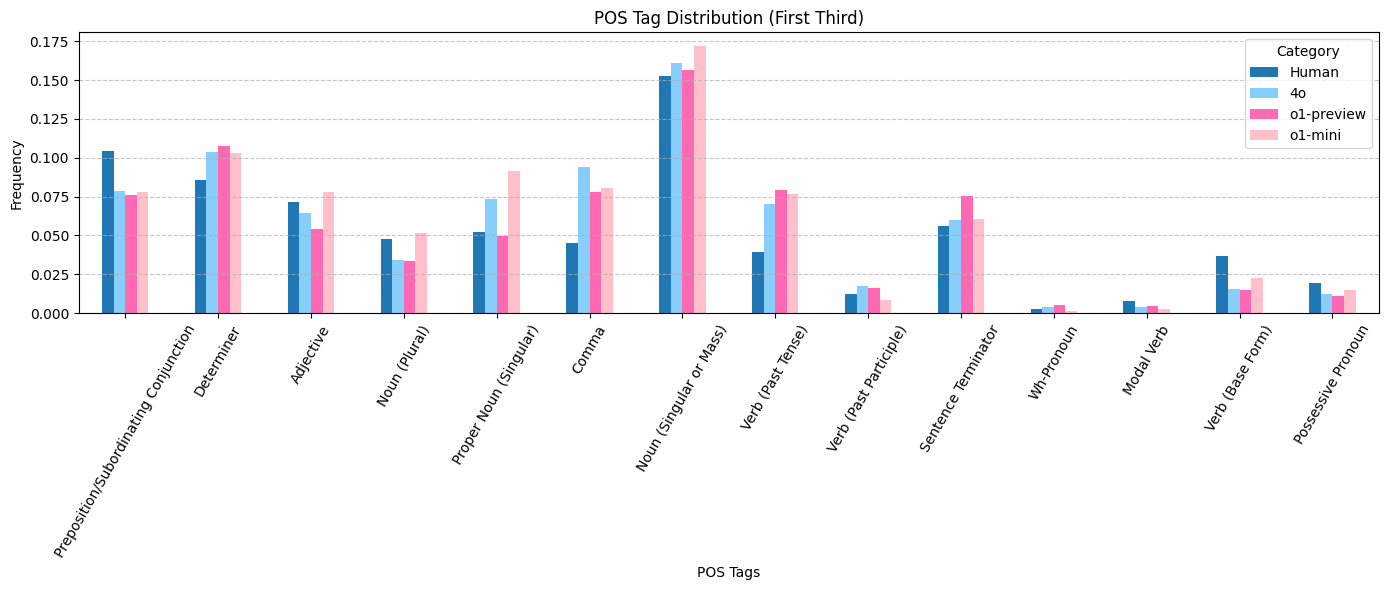

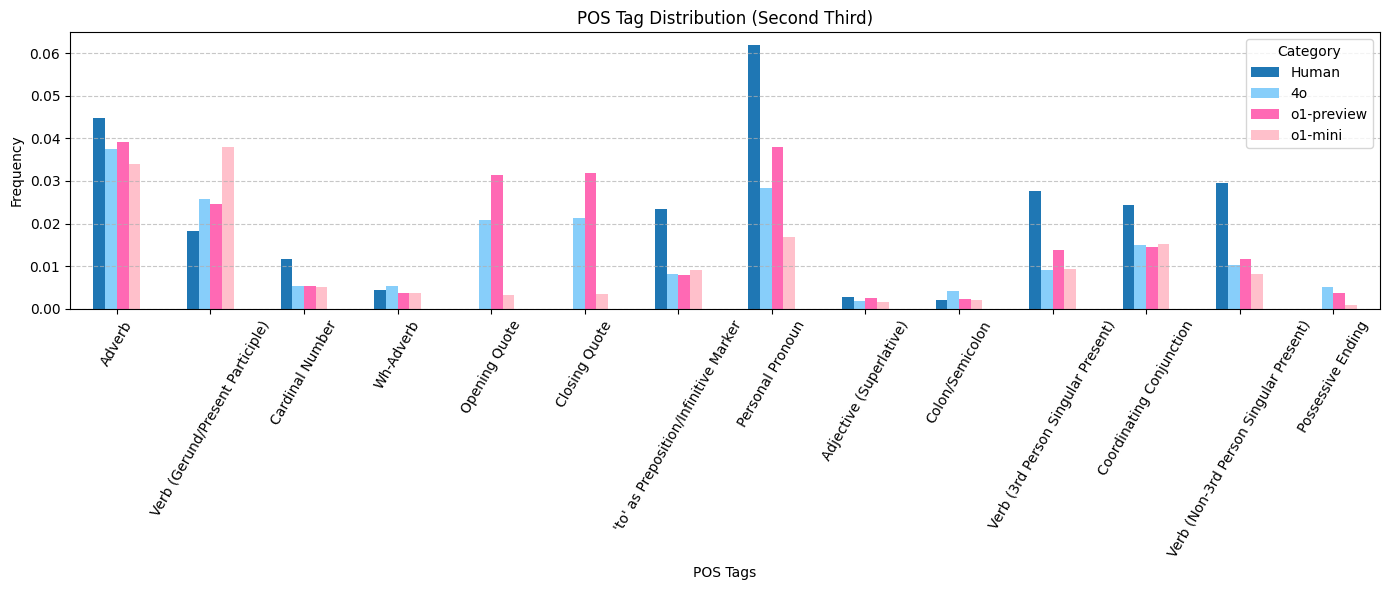

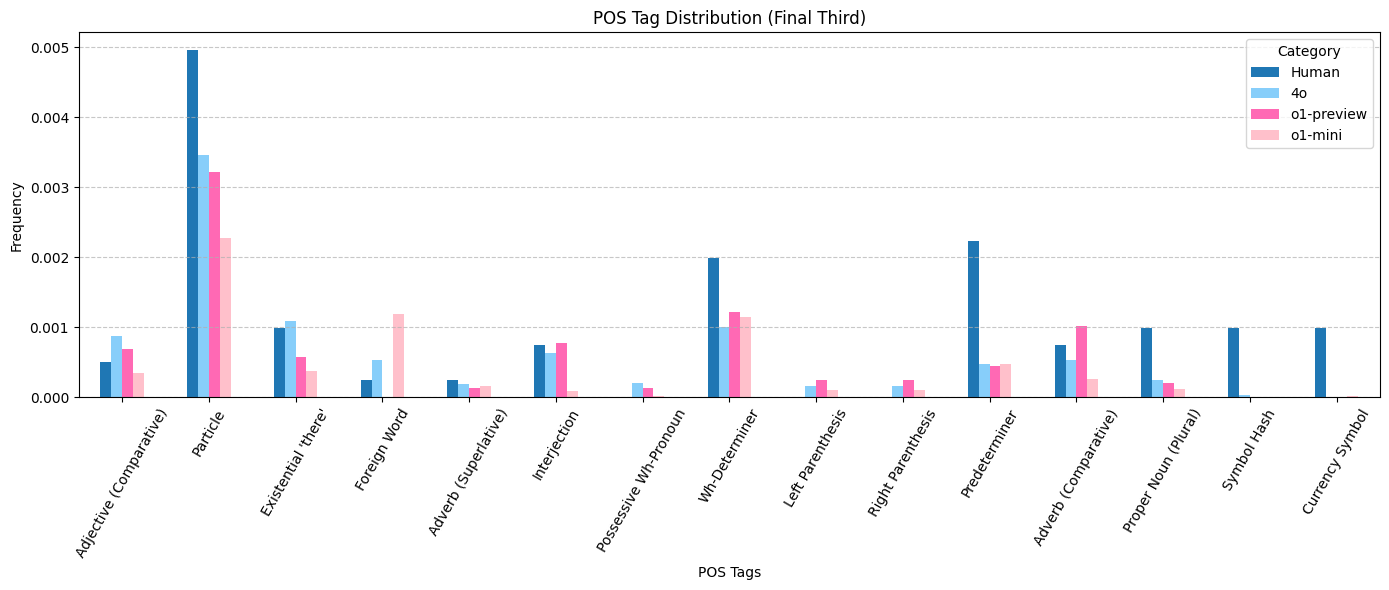

In [ ]:
df_readable = pos_df_readable
split_1 = len(df_readable) // 3
split_2 = 2 * len(df_readable) // 3

df_first = df_readable.iloc[:split_1]
df_second = df_readable.iloc[split_1:split_2]
df_third = df_readable.iloc[split_2:]

# Первый график
fig, ax1 = plt.subplots(figsize=(14, 6))
df_first.plot(kind='bar', ax=ax1, color=[colors_updated.get(col, 'gray') for col in df_readable.columns])
ax1.set_title("POS Tag Distribution (First Third)")
ax1.set_ylabel("Frequency")
ax1.set_xlabel("POS Tags")
ax1.set_xticklabels(df_first.index, rotation=60)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(title="Category")
plt.tight_layout()
plt.savefig("Creativity_4_1.pdf", format="pdf")

# Второй график
fig, ax2 = plt.subplots(figsize=(14, 6))
df_second.plot(kind='bar', ax=ax2, color=[colors_updated.get(col, 'gray') for col in df_readable.columns])
ax2.set_title("POS Tag Distribution (Second Third)")
ax2.set_ylabel("Frequency")
ax2.set_xlabel("POS Tags")
ax2.set_xticklabels(df_second.index, rotation=60)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.legend(title="Category")
plt.tight_layout()
plt.savefig("Creativity_4_2.pdf", format="pdf")

# Третий график
fig, ax3 = plt.subplots(figsize=(14, 6))
df_third.plot(kind='bar', ax=ax3, color=[colors_updated.get(col, 'gray') for col in df_readable.columns])
ax3.set_title("POS Tag Distribution (Final Third)")
ax3.set_ylabel("Frequency")
ax3.set_xlabel("POS Tags")
ax3.set_xticklabels(df_third.index, rotation=60)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.legend(title="Category")
plt.tight_layout()
plt.savefig("Creativity_4_3.pdf", format="pdf")

plt.show()

In [ ]:
pos_descriptions_cleaned = {
    "NNP": "Proper_Noun_Singular",
    "NNPS": "Proper_Noun_Plural",
    "NN": "Noun_Singular_or_Mass",
    "NNS": "Noun_Plural",
    "VB": "Verb_Base",
    "VBD": "Verb_Past",
    "VBG": "Verb_Gerund",
    "VBN": "Verb_PastParticiple",
    "VBP": "Verb_Non3rd_Sing_Pres",
    "VBZ": "Verb_3rd_Sing_Pres",
    "JJ": "Adjective",
    "JJR": "Adjective_Comparative",
    "JJS": "Adjective_Superlative",
    "RB": "Adverb",
    "RBR": "Adverb_Comparative",
    "RBS": "Adverb_Superlative",
    "DT": "Determiner",
    "IN": "Preposition_Or_SubConj",
    "CC": "Coordinating_Conjunction",
    "PRP": "Pronoun_Personal",
    "PRP$": "Pronoun_Possessive",
    "WP": "Pronoun_Wh",
    "WP$": "Pronoun_Wh_Possessive",
    "WRB": "Adverb_Wh",
    "MD": "Modal_Verb",
    "TO": "To_Preposition_Marker",
    "EX": "Existential_There",
    "CD": "Cardinal_Number",
    "PDT": "Predeterminer",
    "POS": "Possessive_Ending",
    "UH": "Interjection",
    ".": "Sentence_Terminator",
    ",": "Comma",
    ":": "Colon_Or_Semicolon",
    "''": "Quote_Closing",
    "``": "Quote_Opening",
    "FW": "Foreign_Word",
    "#": "Symbol_Hash",
    "$": "Symbol_Currency",
    "(": "Paren_Left",
    ")": "Paren_Right",
    "RP": "Particle",
    "WDT": "Wh_Determiner"
}

In [ ]:
def translate_pos_list_clean(pos_list):
    if isinstance(pos_list, str):
        try:
            pos_list = ast.literal_eval(pos_list)
        except Exception:
            return []
    return [pos_descriptions_cleaned.get(tag, tag) for tag in pos_list]

df["POS_Tags"] = df["POS_Tags"].apply(translate_pos_list_clean)

# Classification

In [ ]:
df.head()

Joke Number                                       Joke Content Group Topic  \
0            1  In the mythical lands of TechTopia, an IT depa...    4o    IT   
1            2  In the bustling IT department of Mythical Ente...    4o    IT   
2            3  In the bustling land of Techtopia, a grumpy dr...    4o    IT   
3            4  In the magical IT department of Fantasia Corp,...    4o    IT   
4            5  In a bustling IT office, a griffin, a unicorn,...    4o    IT   

                                          Embeddings  \
0  [0.0036222304, 0.00936651, -0.01764886, 0.0238...   
1  [0.027781865, 0.046091527, -0.021511806, 0.004...   
2  [0.0016672909, 0.052032348, -0.011978956, -0.0...   
3  [0.043501183, 0.031559017, -0.022587745, 0.028...   
4  [0.026997874, 0.028978929, -0.039107878, 0.012...   

                                Joke Content Cleaned  Char_Count  Word_Count  \
0  mythical lands TechTopia, department run team ...         443          82   
1  bustling department Mythical Enterprises, team...         451          76   
2  bustling land Techtopia, grumpy dragon named S...         434          86   
3  magical department Fantasia Corp, unicorns cha...         472          71   
4  bustling office, griffin, unicorn, dragon work...         438         101   

   Unique_Word_Count  TFIDF_Entropy  Word_Freq_Entropy  \
0                 60       3.776763           5.945326   
1                 60       3.802986           5.979508   
2                 62       3.752821           5.978026   
3                 56       3.844585           5.852547   
4                 61       3.635011           5.737172   

                                            POS_Tags  
0  [Preposition_Or_SubConj, Determiner, Adjective...  
1  [Preposition_Or_SubConj, Determiner, Noun_Sing...  
2  [Preposition_Or_SubConj, Determiner, Noun_Sing...  
3  [Preposition_Or_SubConj, Determiner, Adjective...  
4  [Preposition_Or_SubConj, Determiner, Noun_Sing...

In [ ]:
# df['y'] = df['Group'].apply(lambda x: 0 if x[:2] == '4o' else 1)
# df['y'] = df['Group'].apply(lambda x: 0 if x[:2] == '4o' else (1 if x[:2] == 'o1' else 2))
df['y'] = df['Group'].apply(
    lambda x: 0 if x[:2] == '4o' else (1 if x == 'o1-mini' else (2 if x == 'o1-preview' else 3))
)

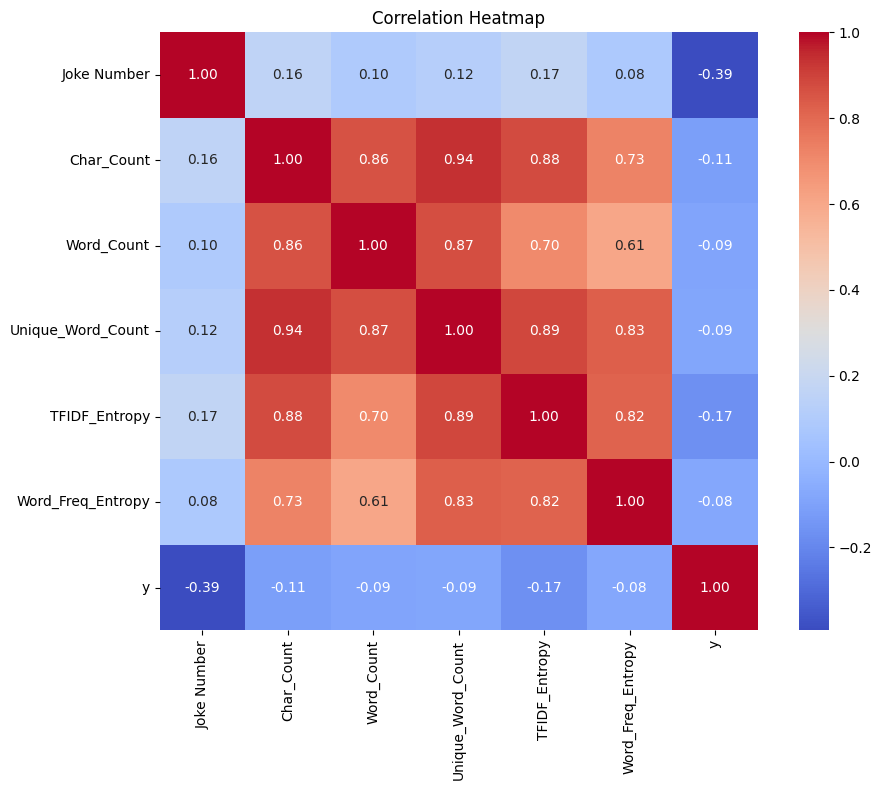

In [ ]:
corr_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

### BERT Fine-Tuning

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Joke Content"].tolist(),
    df["y"].tolist(),
    test_size=0.2,
    stratify=df["y"],
    random_state=42
)

train_labels = [int(label) for label in train_labels]
test_labels = [int(label) for label in test_labels]

In [ ]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

class JokesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=192):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = JokesDataset(train_texts, train_labels, tokenizer)
test_dataset = JokesDataset(test_texts, test_labels, tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions),
        "precision": precision_score(labels, predictions),
        "recall": recall_score(labels, predictions)
    }

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='macro'),
        "precision": precision_score(labels, predictions, average='macro'),
        "recall": recall_score(labels, predictions, average='macro')
    }


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    report_to="none",
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


trainer.train()

TrainOutput(global_step=435, training_loss=0.21776839423839045, metrics={'train_runtime': 171.6545, 'train_samples_per_second': 20.273, 'train_steps_per_second': 2.534, 'total_flos': 343359927244800.0, 'train_loss': 0.21776839423839045, 'epoch': 3.0})

In [ ]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=4)

train_labels = [int(label) for label in train_labels]
test_labels = [int(label) for label in test_labels]

class JokesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=192):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = JokesDataset(train_texts, train_labels, tokenizer)
test_dataset = JokesDataset(test_texts, test_labels, tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    return {
        "accuracy": accuracy_score(labels, predictions),
        "f1": f1_score(labels, predictions, average='macro'),
        "precision": precision_score(labels, predictions, average='macro'),
        "recall": recall_score(labels, predictions, average='macro')
    }

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    num_train_epochs=5,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    report_to="none",
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



TrainOutput(global_step=725, training_loss=0.18708531421127506, metrics={'train_runtime': 290.1125, 'train_samples_per_second': 19.992, 'train_steps_per_second': 2.499, 'total_flos': 572276821708800.0, 'train_loss': 0.18708531421127506, 'epoch': 5.0})

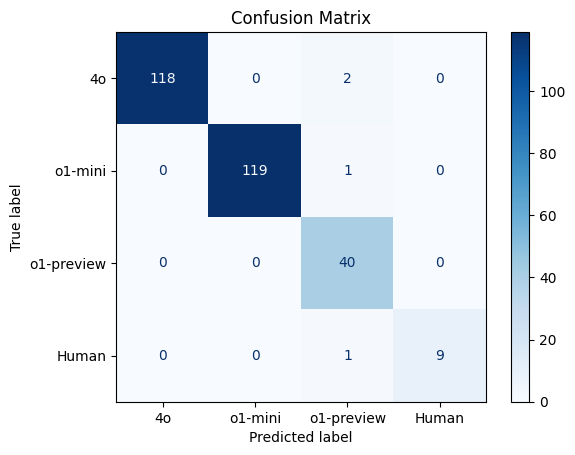

In [ ]:
preds_output = trainer.predict(test_dataset)
preds = preds_output.predictions.argmax(axis=-1)
labels = preds_output.label_ids

cm = confusion_matrix(labels, preds, labels=[0, 1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['4o', 'o1-mini', 'o1-preview', 'Human'])

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

### Logistic Regression

In [ ]:
def run_logit_classification(
    df,
    categorical_cols=None,
    numeric_cols=None,
    target_col='y',
    embedding_cols=None,
    use_pos_tags=False,
    pos_col='POS_Tags',
    drop_first=True,
    test_size=0.2,
    random_state=42
):
    if categorical_cols:
        encoder = OneHotEncoder(drop='first' if drop_first else None, sparse_output=False)
        X_encoded = encoder.fit_transform(df[categorical_cols])
        encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    else:
        encoded_df = pd.DataFrame(index=df.index)

    if numeric_cols:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df[numeric_cols])
        scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols, index=df.index)
    else:
        scaled_df = pd.DataFrame(index=df.index)

    emb_dfs = []
    if embedding_cols:
        for col in embedding_cols:
            emb_series = df[col]
            if not isinstance(emb_series.iloc[0], np.ndarray):
                emb_series = emb_series.apply(np.array)

            emb_matrix = np.vstack(emb_series.values)
            emb_cols = [f"{col}_{i}" for i in range(emb_matrix.shape[1])]
            emb_df = pd.DataFrame(emb_matrix, columns=emb_cols, index=df.index)
            emb_df = pd.DataFrame(StandardScaler().fit_transform(emb_df), columns=emb_cols, index=df.index)
            emb_dfs.append(emb_df)

    emb_df_combined = pd.concat(emb_dfs, axis=1) if emb_dfs else pd.DataFrame(index=df.index)

    if use_pos_tags and pos_col in df.columns:
        def parse_pos(x):
            if isinstance(x, str):
                return ' '.join(ast.literal_eval(x))
            elif isinstance(x, list):
                return ' '.join(x)
            else:
                return ''
        pos_texts = df[pos_col].apply(parse_pos)
        pos_vectorizer = CountVectorizer()
        pos_features = pos_vectorizer.fit_transform(pos_texts)
        pos_df = pd.DataFrame(pos_features.toarray(), columns=pos_vectorizer.get_feature_names_out(), index=df.index)
    else:
        pos_df = pd.DataFrame(index=df.index)

    X = pd.concat([encoded_df, scaled_df, emb_df_combined, pos_df], axis=1)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=df['y'], random_state=random_state)

    model = LogisticRegression(solver='lbfgs', max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("\nℹ️ Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\n" + classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['4o', 'o1-mini', 'o1-preview', 'Human'])
    plt.figure(figsize=(6,6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    coefs = np.mean(np.abs(model.coef_), axis=0)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': coefs
    }).sort_values(by="Importance", ascending=False)

    if len(feature_importance) > 30:
        title = "Top 30 Most Important Features"
    else:
        title = "Feature Importance in Multinomial Logistic Regression"

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")
    plt.xlabel("Feature Importance (Mean Abs. Coefficients)")
    plt.ylabel("Feature")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return model



ℹ️ Evaluation Metrics:
Accuracy : 0.6586
Precision: 0.5773
Recall   : 0.5354
F1 Score : 0.5406

              precision    recall  f1-score   support

           0     0.6218    0.8083    0.7029       120
           1     0.6875    0.7333    0.7097       120
           2     0.0000    0.0000    0.0000        40
           3     1.0000    0.6000    0.7500        10

    accuracy                         0.6586       290
   macro avg     0.5773    0.5354    0.5406       290
weighted avg     0.5763    0.6586    0.6104       290



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<Figure size 600x600 with 0 Axes>

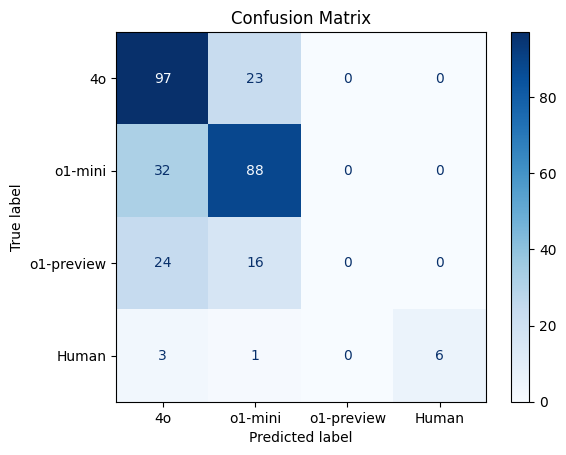

<ipython-input-63-bae24388fb88>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


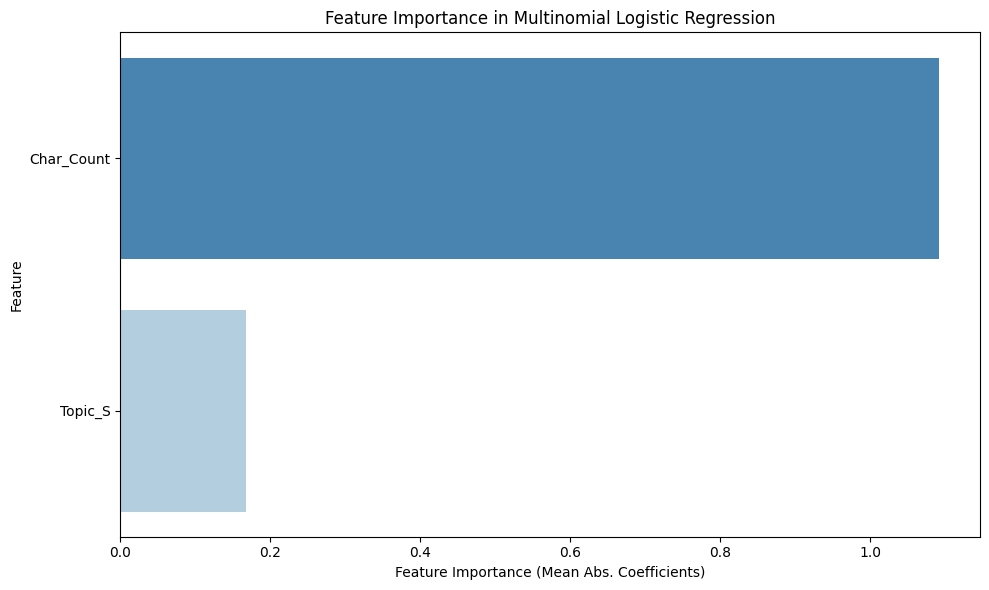

LogisticRegression(max_iter=1000)

In [ ]:
run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count']
)



ℹ️ Evaluation Metrics:
Accuracy : 0.6897
Precision: 0.5948
Recall   : 0.5542
F1 Score : 0.5593

              precision    recall  f1-score   support

           0     0.6200    0.7750    0.6889       120
           1     0.7594    0.8417    0.7984       120
           2     0.0000    0.0000    0.0000        40
           3     1.0000    0.6000    0.7500        10

    accuracy                         0.6897       290
   macro avg     0.5948    0.5542    0.5593       290
weighted avg     0.6053    0.6897    0.6413       290



<Figure size 600x600 with 0 Axes>

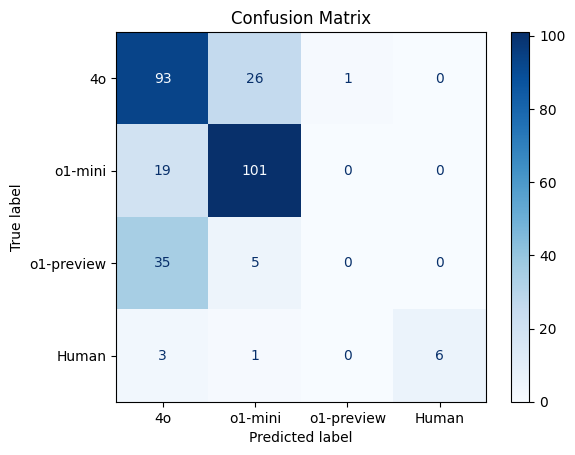

<ipython-input-63-bae24388fb88>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


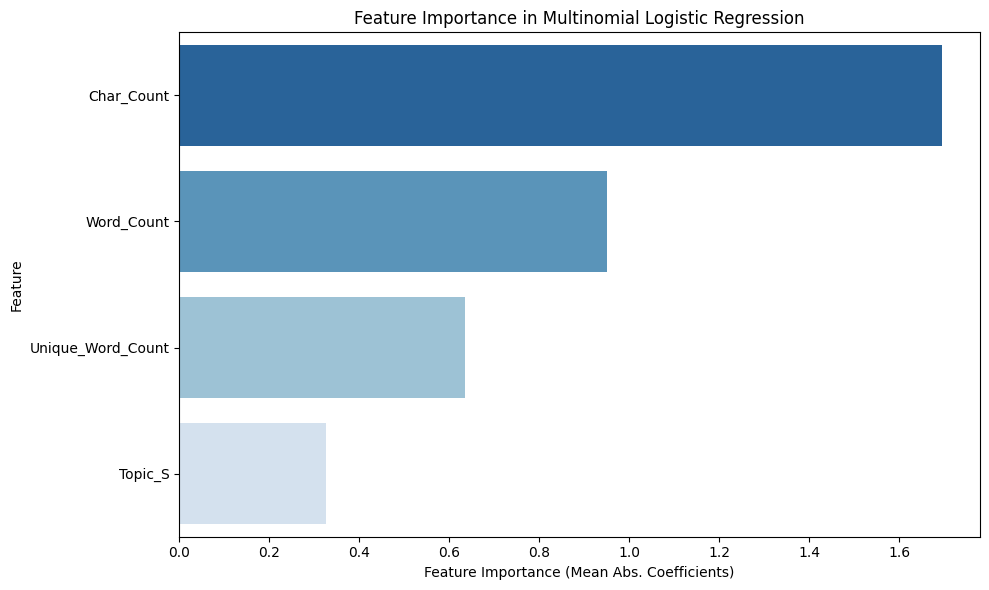

LogisticRegression(max_iter=1000)

In [ ]:
run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count']
)



ℹ️ Evaluation Metrics:
Accuracy : 0.6931
Precision: 0.6001
Recall   : 0.5563
F1 Score : 0.5622

              precision    recall  f1-score   support

           0     0.6101    0.8083    0.6953       120
           1     0.7903    0.8167    0.8033       120
           2     0.0000    0.0000    0.0000        40
           3     1.0000    0.6000    0.7500        10

    accuracy                         0.6931       290
   macro avg     0.6001    0.5563    0.5622       290
weighted avg     0.6140    0.6931    0.6460       290



<Figure size 600x600 with 0 Axes>

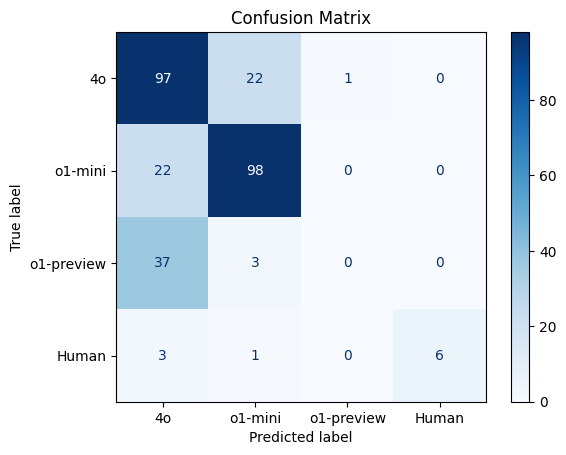

<ipython-input-63-bae24388fb88>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


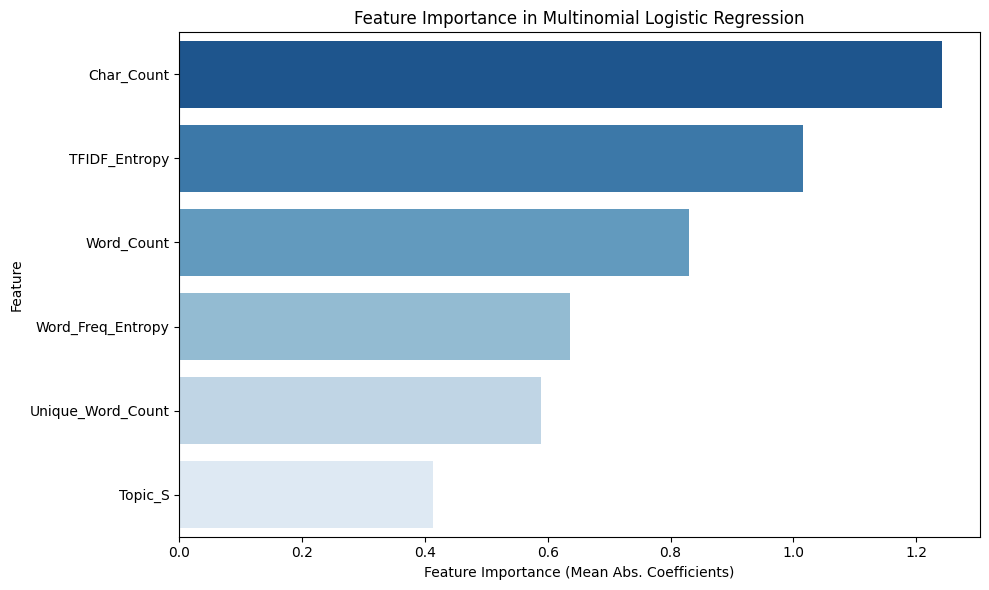

LogisticRegression(max_iter=1000)

In [ ]:
run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy']
)



ℹ️ Evaluation Metrics:
Accuracy : 0.7655
Precision: 0.7621
Recall   : 0.5854
F1 Score : 0.6034


<Figure size 600x600 with 0 Axes>

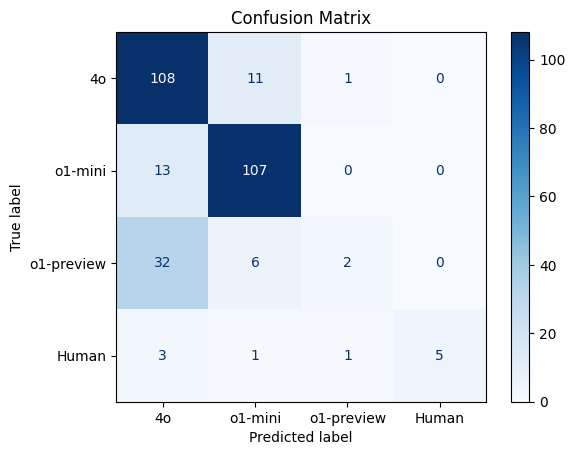

<ipython-input-40-da290b49028a>:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


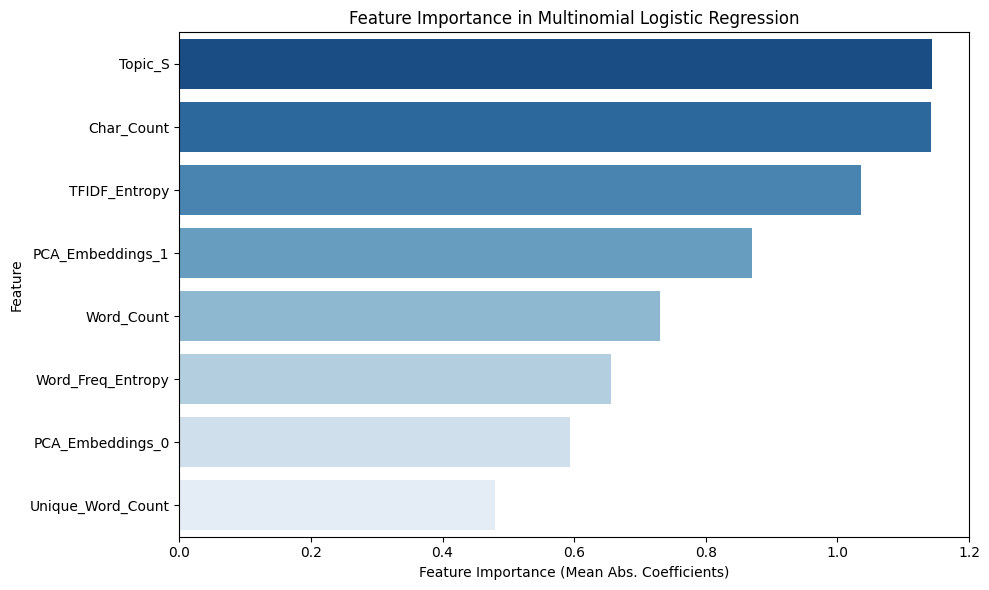

LogisticRegression(max_iter=1000)

In [ ]:
run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    embedding_cols=["PCA_Embeddings"]

)


ℹ️ Evaluation Metrics:
Accuracy : 0.8517
Precision: 0.8373
Recall   : 0.8562
F1 Score : 0.8459

              precision    recall  f1-score   support

           0     0.8509    0.8083    0.8291       120
           1     0.8968    0.9417    0.9187       120
           2     0.6923    0.6750    0.6835        40
           3     0.9091    1.0000    0.9524        10

    accuracy                         0.8517       290
   macro avg     0.8373    0.8562    0.8459       290
weighted avg     0.8500    0.8517    0.8503       290



<Figure size 600x600 with 0 Axes>

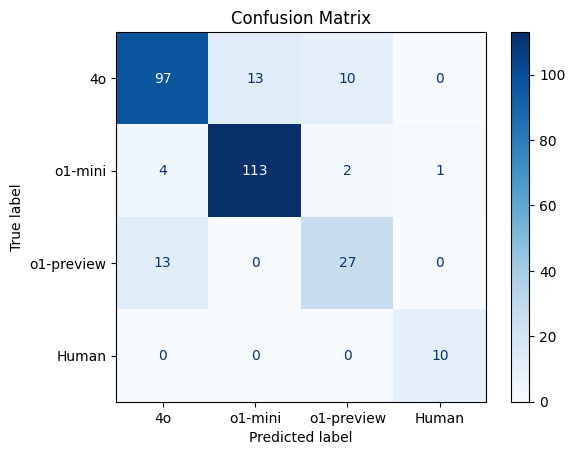

<ipython-input-63-bae24388fb88>:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


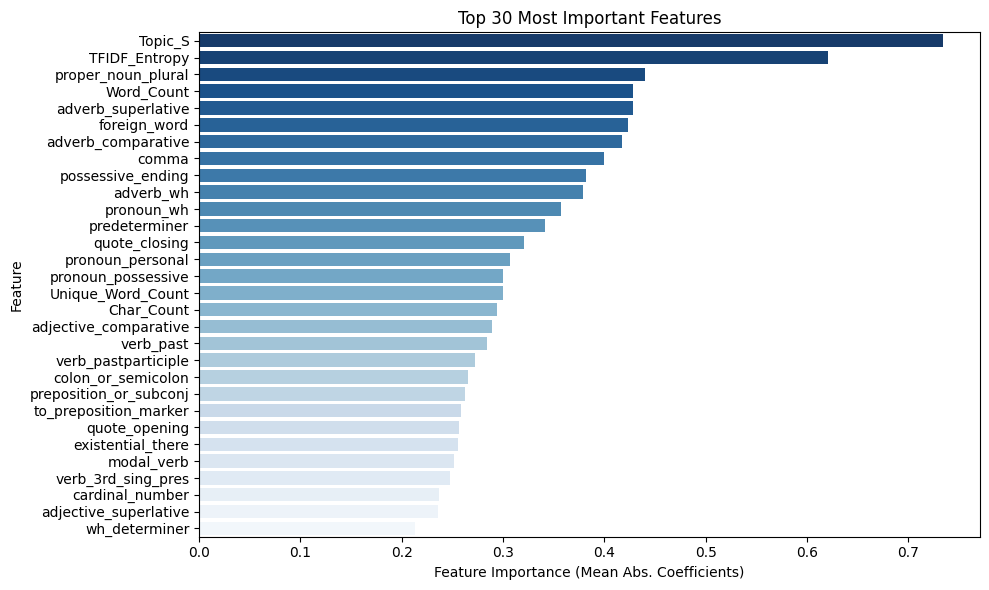

LogisticRegression(max_iter=1000)

In [ ]:
run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    use_pos_tags=True

)

Переключаемся на Logistic Regression из sklearn, чтобы использовать модель с разными эмбеддингами. Иначе ошибки: overflow / singular matrix

In [ ]:
def run_logit_classification(
    df,
    categorical_cols=None,
    numeric_cols=None,
    target_col='y',
    embedding_cols=None,
    use_pos_tags=False,
    pos_col='POS_Tags',
    other_text_features=None,
    text_col='Joke Content',
    drop_first=True,
    threshold=0.5,
    test_size=0.2,
    random_state=42,
    penalty='l2',
    C=1.0,
    max_iter=1000
):
    if categorical_cols:
        encoder = OneHotEncoder(drop='first' if drop_first else None, sparse_output=False)
        X_encoded = encoder.fit_transform(df[categorical_cols])
        encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    else:
        encoded_df = pd.DataFrame(index=df.index)

    if numeric_cols:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(df[numeric_cols])
        scaled_df = pd.DataFrame(X_scaled, columns=numeric_cols, index=df.index)
    else:
        scaled_df = pd.DataFrame(index=df.index)

    emb_dfs = []
    if embedding_cols:
        for col in embedding_cols:
            emb_series = df[col]
            if not isinstance(emb_series.iloc[0], np.ndarray):
                emb_series = emb_series.apply(np.array)
            emb_matrix = np.vstack(emb_series.values)
            emb_cols = [f"{col}_{i}" for i in range(emb_matrix.shape[1])]
            emb_df = pd.DataFrame(emb_matrix, columns=emb_cols, index=df.index)
            emb_df = pd.DataFrame(StandardScaler().fit_transform(emb_df), columns=emb_cols, index=df.index)
            emb_dfs.append(emb_df)
    emb_df_combined = pd.concat(emb_dfs, axis=1) if emb_dfs else pd.DataFrame(index=df.index)

    if use_pos_tags and pos_col in df.columns:
        def parse_pos(x):
            if isinstance(x, str):
                return ' '.join(ast.literal_eval(x))
            elif isinstance(x, list):
                return ' '.join(x)
            else:
                return ''
        pos_texts = df[pos_col].apply(parse_pos)
        pos_vectorizer = CountVectorizer()
        pos_features = pos_vectorizer.fit_transform(pos_texts)
        pos_df = pd.DataFrame(pos_features.toarray(), columns=pos_vectorizer.get_feature_names_out(), index=df.index)
    else:
        pos_df = pd.DataFrame(index=df.index)

    if other_text_features and text_col in df.columns:
        if isinstance(df[text_col].iloc[0], float):
            df[text_col] = df[text_col].fillna("")
        if "TF_IDF" in other_text_features:
            vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        elif "bag_of_words" in other_text_features:
            vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        else:
            vectorizer = None

        if vectorizer:
            text_matrix = vectorizer.fit_transform(df[text_col])
            text_df = pd.DataFrame(text_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
    else:
        text_df = pd.DataFrame(index=df.index)

    X = pd.concat([encoded_df, scaled_df, emb_df_combined, pos_df, text_df], axis=1)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=df['y'], random_state=random_state)

    model = LogisticRegression(penalty=penalty, C=C, max_iter=max_iter, solver='lbfgs')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("\nℹ️ Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\n" + classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['4o', 'o1-mini', 'o1-preview', 'Human'])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    if len(model.coef_) == 1:
        coefs = model.coef_[0]
    else:
        coefs = np.mean(np.abs(model.coef_), axis=0)

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': coefs
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")
    plt.xlabel("Feature Importance (Abs. Coefficients)")
    plt.ylabel("Feature")
    plt.title("Top 30 Most Important Features")
    plt.tight_layout()
    plt.show()

    return model


ℹ️ Evaluation Metrics:
Accuracy : 0.9414
Precision: 0.9376
Recall   : 0.9313
F1 Score : 0.9343

              precision    recall  f1-score   support

           0     0.9328    0.9250    0.9289       120
           1     0.9756    1.0000    0.9877       120
           2     0.8421    0.8000    0.8205        40
           3     1.0000    1.0000    1.0000        10

    accuracy                         0.9414       290
   macro avg     0.9376    0.9313    0.9343       290
weighted avg     0.9403    0.9414    0.9407       290



<Figure size 600x600 with 0 Axes>

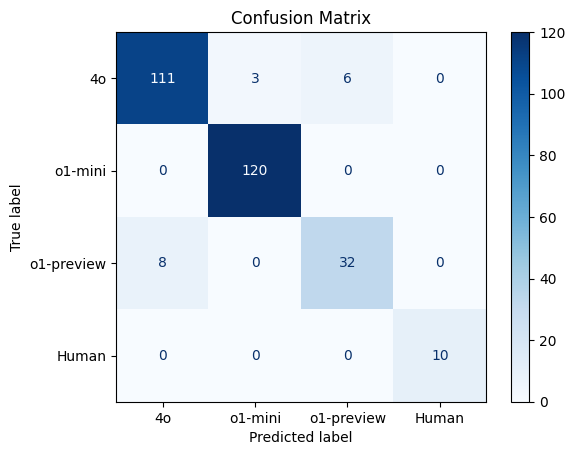

<ipython-input-69-fd1a0fceb25b>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


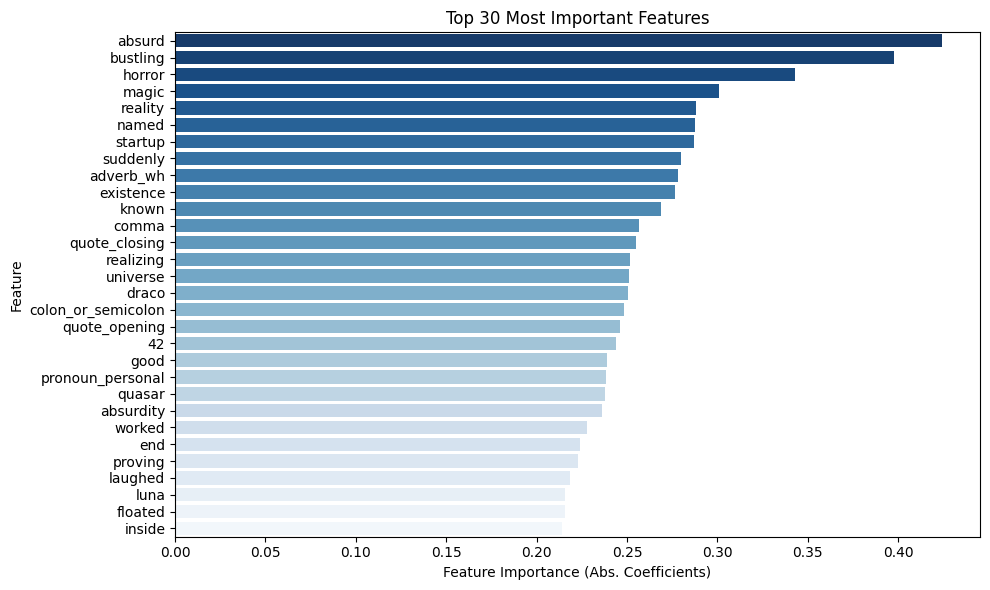

In [ ]:
lr = run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    other_text_features=['bag_of_words'],
    use_pos_tags=True
)


ℹ️ Evaluation Metrics:
Accuracy : 0.8862
Precision: 0.8915
Recall   : 0.8771
F1 Score : 0.8833

              precision    recall  f1-score   support

           0     0.8739    0.8667    0.8703       120
           1     0.9206    0.9667    0.9431       120
           2     0.7714    0.6750    0.7200        40
           3     1.0000    1.0000    1.0000        10

    accuracy                         0.8862       290
   macro avg     0.8915    0.8771    0.8833       290
weighted avg     0.8835    0.8862    0.8842       290



<Figure size 600x600 with 0 Axes>

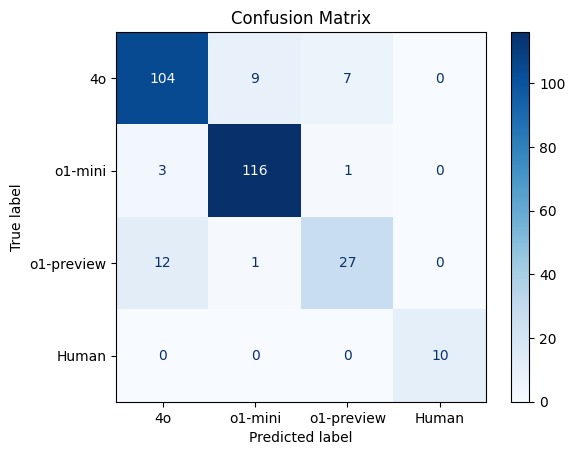

<ipython-input-58-fd1a0fceb25b>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


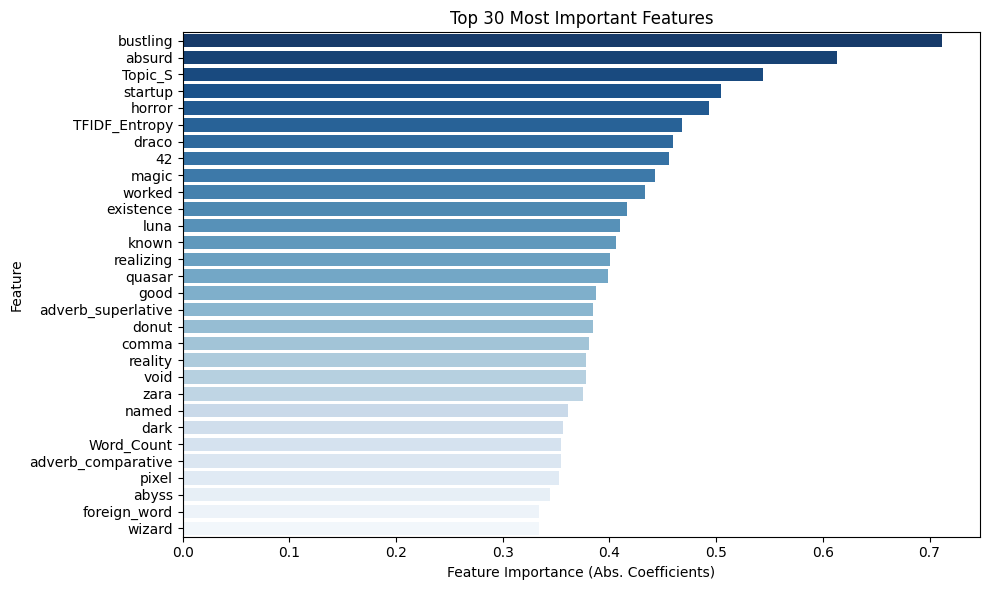

In [ ]:
lr = run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    other_text_features=['TF_IDF'],
    use_pos_tags=True
)


ℹ️ Evaluation Metrics:
Accuracy : 0.8655
Precision: 0.8501
Recall   : 0.8687
F1 Score : 0.8588

              precision    recall  f1-score   support

           0     0.8547    0.8333    0.8439       120
           1     0.9187    0.9417    0.9300       120
           2     0.7179    0.7000    0.7089        40
           3     0.9091    1.0000    0.9524        10

    accuracy                         0.8655       290
   macro avg     0.8501    0.8687    0.8588       290
weighted avg     0.8642    0.8655    0.8647       290



<Figure size 600x600 with 0 Axes>

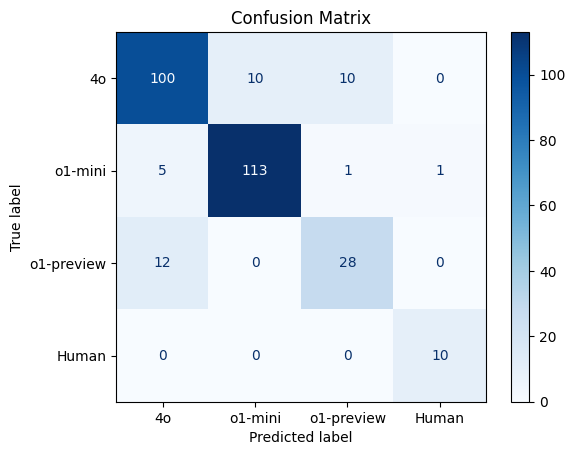

<ipython-input-58-fd1a0fceb25b>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


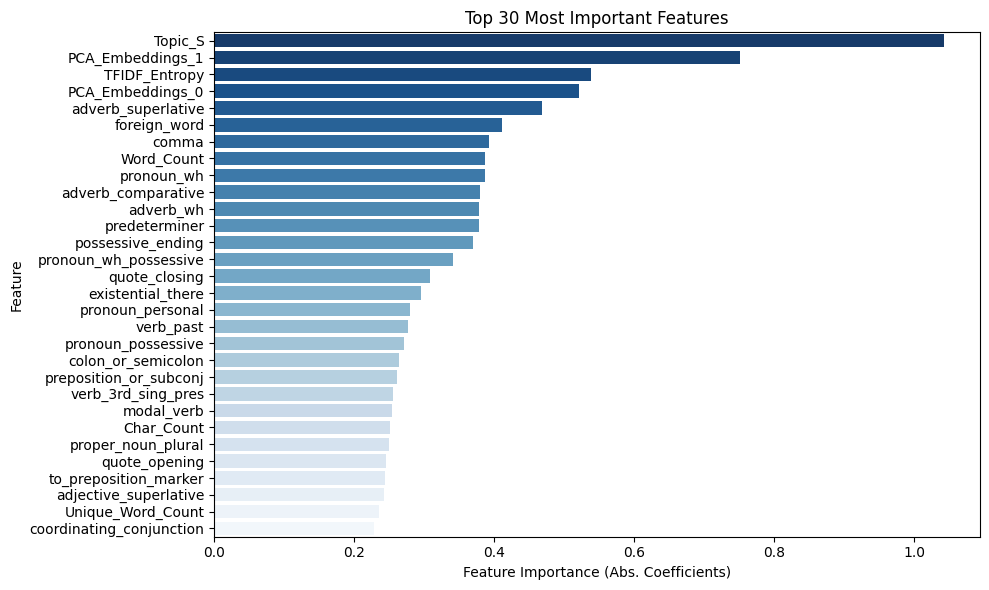

In [ ]:
lr = run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    embedding_cols=["PCA_Embeddings"],
    use_pos_tags=True

)


ℹ️ Evaluation Metrics:
Accuracy : 0.9276
Precision: 0.9223
Recall   : 0.9083
F1 Score : 0.9143

              precision    recall  f1-score   support

           0     0.9397    0.9083    0.9237       120
           1     0.9590    0.9750    0.9669       120
           2     0.7907    0.8500    0.8193        40
           3     1.0000    0.9000    0.9474        10

    accuracy                         0.9276       290
   macro avg     0.9223    0.9083    0.9143       290
weighted avg     0.9292    0.9276    0.9280       290



<Figure size 600x600 with 0 Axes>

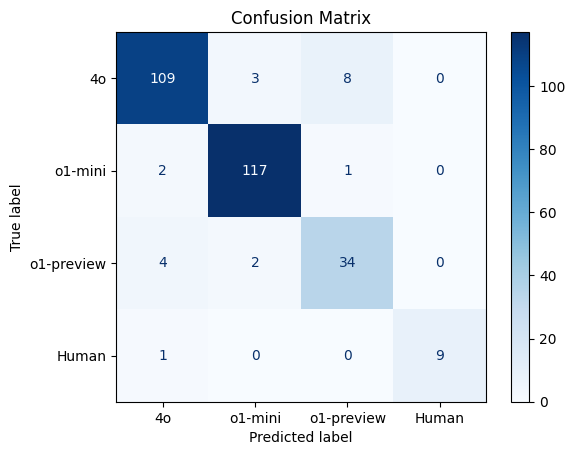

<ipython-input-58-fd1a0fceb25b>:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Blues_r")


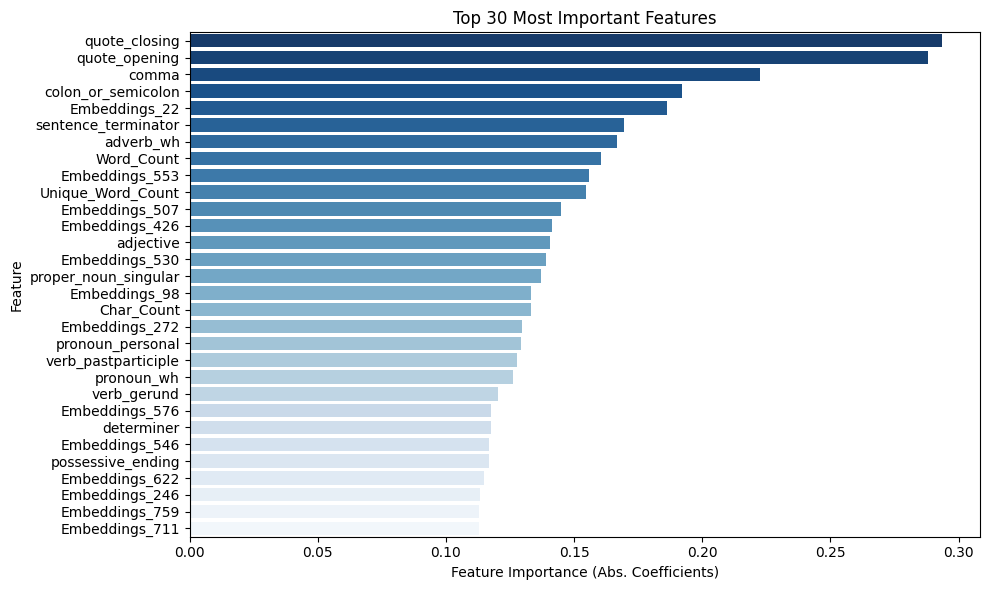

In [ ]:
lr = run_logit_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    embedding_cols=["Embeddings"],
    use_pos_tags=True

)

### Random Forest

In [ ]:
def run_random_forest_classification(
    df,
    categorical_cols=None,
    numeric_cols=None,
    target_col='y',
    embedding_cols=None,
    use_pos_tags=False,
    pos_col='POS_Tags',
    other_text_features=None,
    text_col='Joke Content',
    drop_first=True,
    test_size=0.2,
    random_state=42,
    n_estimators=100,
    max_depth=None
):
    if categorical_cols:
        encoder = OneHotEncoder(drop='first' if drop_first else None, sparse_output=False)
        X_encoded = encoder.fit_transform(df[categorical_cols])
        encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols), index=df.index)
    else:
        encoded_df = pd.DataFrame(index=df.index)

    scaled_df = df[numeric_cols] if numeric_cols else pd.DataFrame(index=df.index)

    emb_dfs = []
    if embedding_cols:
        for col in embedding_cols:
            emb_series = df[col]
            if not isinstance(emb_series.iloc[0], np.ndarray):
                emb_series = emb_series.apply(np.array)
            emb_matrix = np.vstack(emb_series.values)
            emb_cols = [f"{col}_{i}" for i in range(emb_matrix.shape[1])]
            emb_df = pd.DataFrame(emb_matrix, columns=emb_cols, index=df.index)
            emb_dfs.append(emb_df)
    emb_df_combined = pd.concat(emb_dfs, axis=1) if emb_dfs else pd.DataFrame(index=df.index)

    if use_pos_tags and pos_col in df.columns:
        def parse_pos(x):
            if isinstance(x, str):
                return ' '.join(ast.literal_eval(x))
            elif isinstance(x, list):
                return ' '.join(x)
            else:
                return ''
        pos_texts = df[pos_col].apply(parse_pos)
        pos_vectorizer = CountVectorizer()
        pos_features = pos_vectorizer.fit_transform(pos_texts)
        pos_df = pd.DataFrame(pos_features.toarray(), columns=pos_vectorizer.get_feature_names_out(), index=df.index)
    else:
        pos_df = pd.DataFrame(index=df.index)

    if other_text_features and text_col in df.columns:
        if isinstance(df[text_col].iloc[0], float):  # пустые или NaN
            df[text_col] = df[text_col].fillna("")
        if "TF_IDF" in other_text_features:
            vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        elif "bag_of_words" in other_text_features:
            vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        else:
            vectorizer = None

        if vectorizer:
            text_matrix = vectorizer.fit_transform(df[text_col])
            text_df = pd.DataFrame(text_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)
    else:
        text_df = pd.DataFrame(index=df.index)

    X = pd.concat([encoded_df, scaled_df, emb_df_combined, pos_df, text_df], axis=1)
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')

    print("\nℹ️ Evaluation Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("\n" + classification_report(y_test, y_pred, digits=4))

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['4o', 'o1-mini', 'o1-preview', 'Human'])
    plt.figure(figsize=(6, 6))
    disp.plot(cmap="Greens", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Greens_r")
    plt.xlabel("Feature Importance (Random Forest)")
    plt.ylabel("Feature")
    plt.title("Top 30 Most Important Features")
    plt.tight_layout()
    plt.show()

    return model


ℹ️ Evaluation Metrics:
Accuracy : 0.8241
Precision: 0.8412
Recall   : 0.7479
F1 Score : 0.7809

              precision    recall  f1-score   support

           0     0.7591    0.8667    0.8093       120
           1     0.9098    0.9250    0.9174       120
           2     0.6957    0.4000    0.5079        40
           3     1.0000    0.8000    0.8889        10

    accuracy                         0.8241       290
   macro avg     0.8412    0.7479    0.7809       290
weighted avg     0.8210    0.8241    0.8152       290



<Figure size 600x600 with 0 Axes>

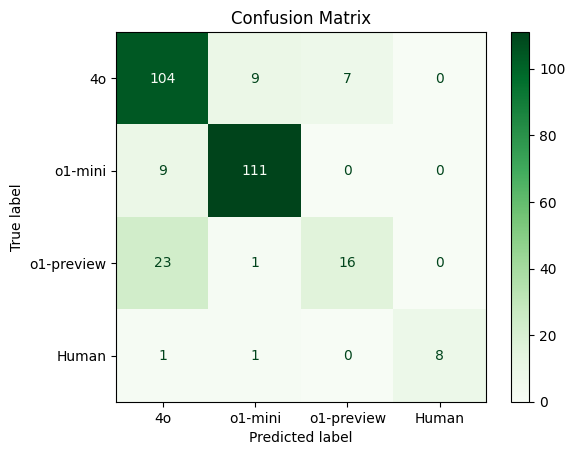

<ipython-input-56-1a5bfff085c5>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Greens_r")


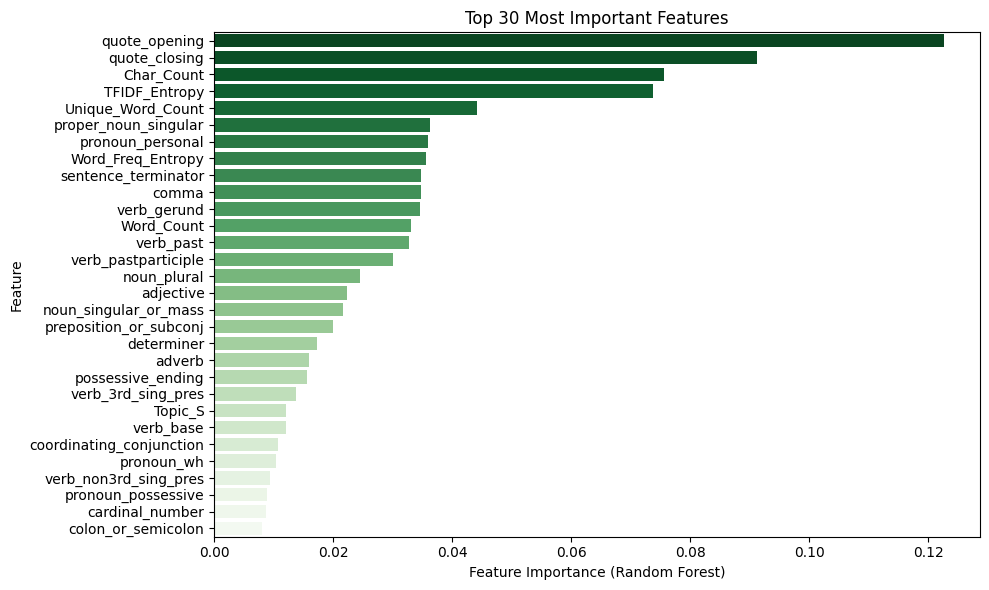

In [ ]:
model_rf = run_random_forest_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    use_pos_tags=True,
    n_estimators=100,
    max_depth=20
)


ℹ️ Evaluation Metrics:
Accuracy : 0.8759
Precision: 0.9216
Recall   : 0.7708
F1 Score : 0.8082

              precision    recall  f1-score   support

           0     0.7945    0.9667    0.8722       120
           1     0.9587    0.9667    0.9627       120
           2     0.9333    0.3500    0.5091        40
           3     1.0000    0.8000    0.8889        10

    accuracy                         0.8759       290
   macro avg     0.9216    0.7708    0.8082       290
weighted avg     0.8887    0.8759    0.8601       290



<Figure size 600x600 with 0 Axes>

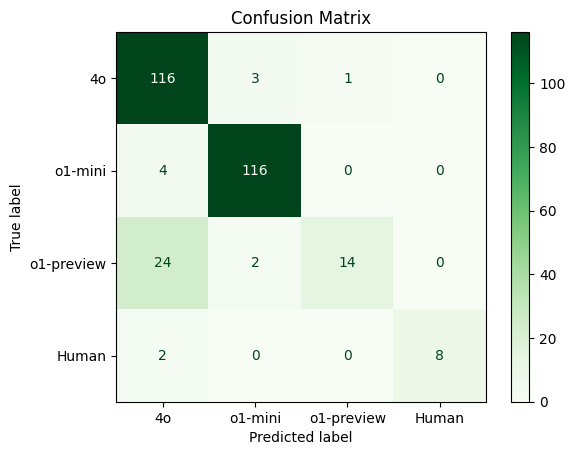

<ipython-input-56-1a5bfff085c5>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Greens_r")


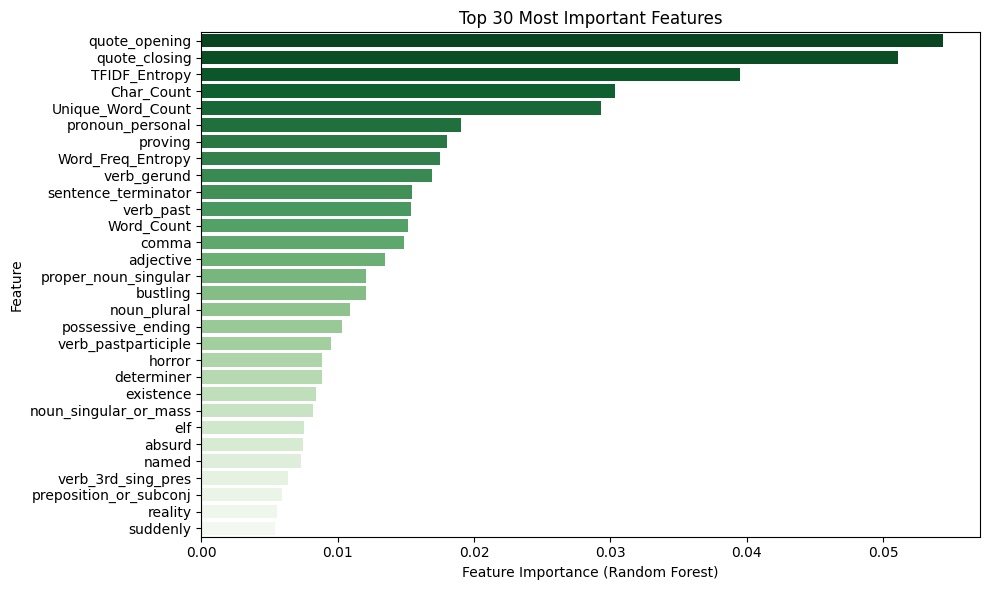

In [ ]:
model_rf = run_random_forest_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    other_text_features=['bag_of_words'],
    use_pos_tags=True,
    n_estimators=200,
    max_depth=20
)


ℹ️ Evaluation Metrics:
Accuracy : 0.8759
Precision: 0.9206
Recall   : 0.7479
F1 Score : 0.7926

              precision    recall  f1-score   support

           0     0.8056    0.9667    0.8788       120
           1     0.9435    0.9750    0.9590       120
           2     0.9333    0.3500    0.5091        40
           3     1.0000    0.7000    0.8235        10

    accuracy                         0.8759       290
   macro avg     0.9206    0.7479    0.7926       290
weighted avg     0.8870    0.8759    0.8591       290



<Figure size 600x600 with 0 Axes>

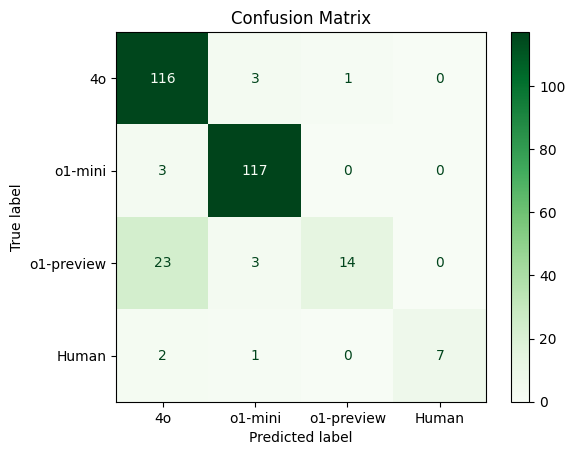

<ipython-input-56-1a5bfff085c5>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Greens_r")


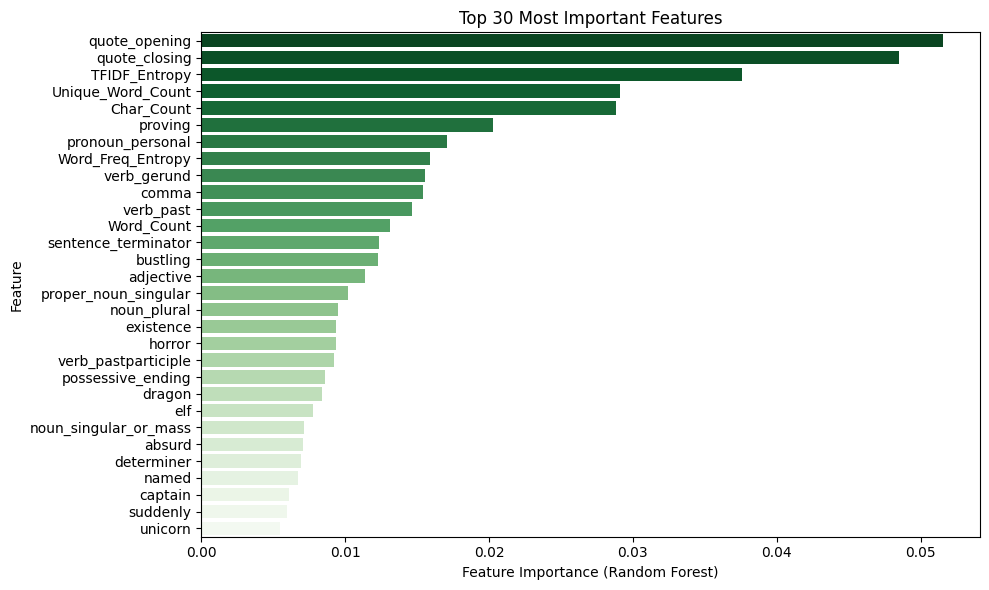

In [ ]:
model_rf = run_random_forest_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    other_text_features=['TF_IDF'],
    use_pos_tags=True,
    n_estimators=200,
    max_depth=20
)


ℹ️ Evaluation Metrics:
Accuracy : 0.8517
Precision: 0.8691
Recall   : 0.7729
F1 Score : 0.8076

              precision    recall  f1-score   support

           0     0.7857    0.9167    0.8462       120
           1     0.9407    0.9250    0.9328       120
           2     0.7500    0.4500    0.5625        40
           3     1.0000    0.8000    0.8889        10

    accuracy                         0.8517       290
   macro avg     0.8691    0.7729    0.8076       290
weighted avg     0.8523    0.8517    0.8443       290



<Figure size 600x600 with 0 Axes>

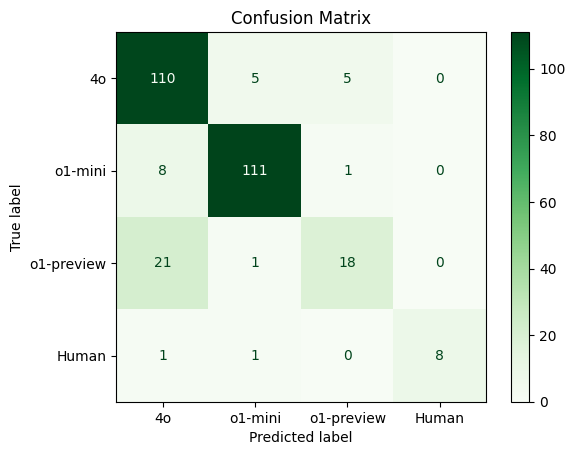

<ipython-input-56-1a5bfff085c5>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Greens_r")


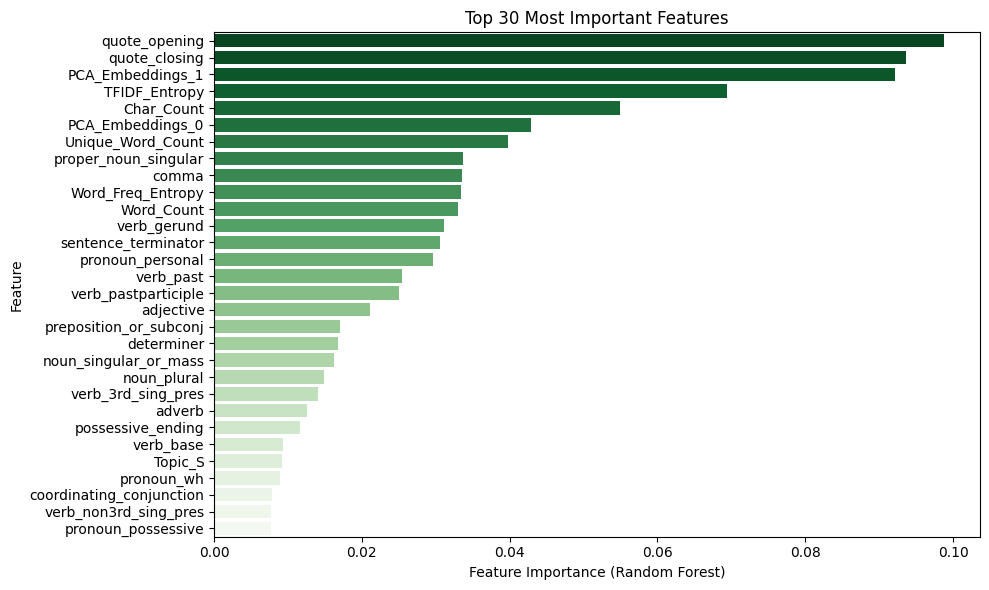

In [ ]:
model_rf = run_random_forest_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    embedding_cols=['PCA_Embeddings'],
    use_pos_tags=True,
    n_estimators=100,
    max_depth=20
)


ℹ️ Evaluation Metrics:
Accuracy : 0.8241
Precision: 0.9164
Recall   : 0.6708
F1 Score : 0.6834

              precision    recall  f1-score   support

           0     0.7233    0.9583    0.8244       120
           1     0.9421    0.9500    0.9461       120
           2     1.0000    0.0750    0.1395        40
           3     1.0000    0.7000    0.8235        10

    accuracy                         0.8241       290
   macro avg     0.9164    0.6708    0.6834       290
weighted avg     0.8616    0.8241    0.7802       290



<Figure size 600x600 with 0 Axes>

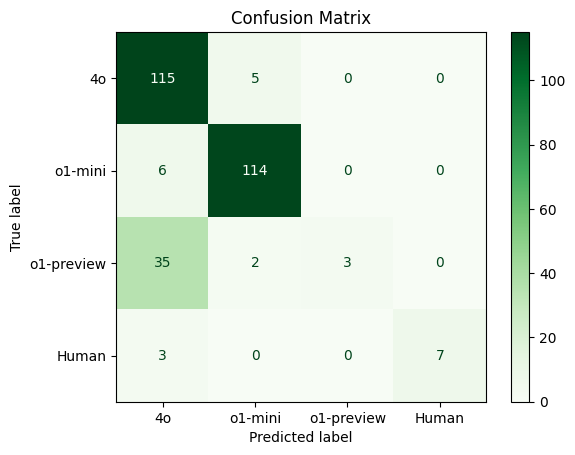

<ipython-input-56-1a5bfff085c5>:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feature_importance.head(30), palette="Greens_r")


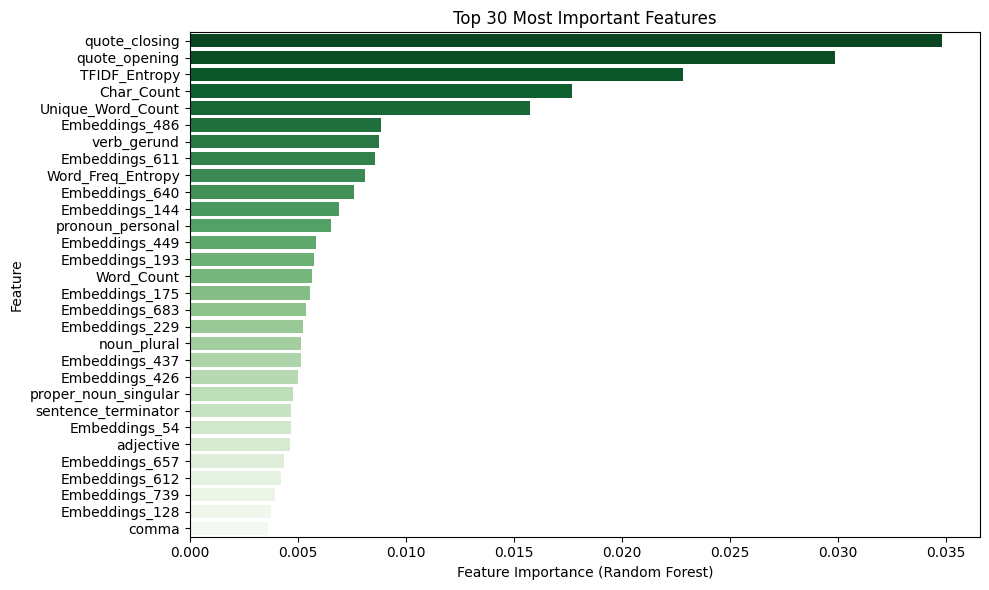

In [ ]:
model_rf = run_random_forest_classification(
    df,
    categorical_cols=['Topic'],
    numeric_cols=['Char_Count', 'Word_Count', 'Unique_Word_Count', 'TFIDF_Entropy', 'Word_Freq_Entropy'],
    embedding_cols=['Embeddings'],
    use_pos_tags=True,
    n_estimators=300,
    max_depth=20
)